In [1]:
# importing all the required libraries

import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats

In [2]:
# importing the file with the combined data of both the hospitals and splitting it into 2 parts

combined = pd.read_csv('Dataset.csv')

rows_to_drop = combined.loc[combined['Patient_ID'].apply(lambda x: len(str(x)) == 6)]
df_train = combined.drop(rows_to_drop.index)
df_train.to_csv('data_part1.csv', index=False)

rows_to_drop = combined.loc[combined['Patient_ID'].apply(lambda x: len(str(x)) != 6)]
df_test = combined.drop(rows_to_drop.index)
df_test.to_csv('data_part2.csv', index=False)

In [3]:
# importing the test and training data

df_train = pd.read_csv('data_part1.csv')
df_test = pd.read_csv('data_part2.csv')

In [4]:
df_train.head(15)

,Unnamed: 0,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,1,0,17072
1,1,1,65.0,100.0,NaN,NaN,72.0,NaN,16.5,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,2,0,17072
2,2,2,78.0,100.0,NaN,NaN,42.5,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,3,0,17072
3,3,3,73.0,100.0,NaN,NaN,NaN,NaN,17.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,4,0,17072
4,4,4,70.0,100.0,NaN,129.0,74.0,69.0,14.0,NaN,...,NaN,330.0,68.54,0,NaN,NaN,-0.02,5,0,17072
5,5,5,62.0,100.0,NaN,124.0,85.0,61.0,14.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,6,0,17072
6,6,6,61.0,100.0,NaN,101.0,75.0,58.0,14.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,7,0,17072
7,7,7,68.0,100.0,35.78,142.0,93.5,78.0,16.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,8,0,17072
8,8,8,71.0,100.0,NaN,121.0,74.0,91.0,14.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,9,0,17072
9,9,9,69.0,100.0,NaN,120.0,79.0,98.0,14.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,10,0,17072


In [5]:
# let's list down all the different columns

df_train.columns

Index(['Unnamed: 0', 'Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP',
       'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2',
       'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine',
       'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate',
       'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel', 'Patient_ID'],
      dtype='object')

In [6]:
# list of all the unique patients
# total number of patients present in the dataset

patients = list(df_test['Patient_ID'].unique())
len(patients)

20000

In [7]:
# Function to draw correlation heat map 
def corr_matrix(df):
  corr = df.corr()
  mask = np.triu(np.ones_like(corr, dtype=bool))
  f, ax = plt.subplots(figsize=(40,40))
  cmap = sns.diverging_palette(220, 10, as_cmap=True)
  sns.heatmap(corr, mask=mask, cmap="Paired", vmax=.3, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [8]:
# Percentage of null values present in all the parameters 
null_values = df_train.isnull().mean()*100
null_values = null_values.sort_values(ascending=False)
null_values

EtCO2               100.000000
TroponinI            99.877881
Bilirubin_direct     99.850420
Fibrinogen           99.236917
Bilirubin_total      98.773372
Alkalinephos         98.540650
AST                  98.504205
Lactate              96.565112
PTT                  95.152459
SaO2                 95.044387
Calcium              95.024392
Phosphate            94.951247
Platelets            93.482913
Creatinine           93.357884
WBC                  92.489639
Magnesium            92.219712
HCO3                 91.949406
BUN                  91.840702
Chloride             91.676063
PaCO2                91.231753
Hgb                  91.164303
BaseExcess           89.574863
Potassium            89.137640
pH                   88.532868
Hct                  88.223711
Glucose              87.768392
FiO2                 85.807027
Temp                 66.224255
Unit1                48.868346
Unit2                48.868346
DBP                  48.125763
SBP                  15.211177
O2Sat   

In [9]:
# the features have been removed based on the number of null values and redundancy 

# 'Unnamed: 0'-- this is the index column
# 'SBP' -- MAP is considered instead of SBP and DBP
# 'DBP' -- MAP is considered instead of SBP and DBP
# 'EtCO2' -- It is not readily. available and also not available in the dataset
# 'BaseExcess' -- It is an indicator of the health of kidney and pancreas but is redundant here becuase a lot of different features for kidney are being considered here. 
# 'HCO3' -- It is also an indicator of the health of kidney and pancreas but is redundant here becuase a lot of different features for kidney are being considered here.
# 'pH' -- It is also an indicator of the health of kidney and pancreas but is redundant here becuase a lot of different features for kidney are being considered here.
# 'PaCO2' -- It is an indicator of respiratory health of an individual, we are considering SaO2 and FiO2 which are more readily avaiilable
# 'Alkalinephos' -- It is an indicator of the health of the liver of an individual, but we are considering Bilirubin instead of this, as data of this is more scarce.
# 'Calcium' -- It is also an indicator of the health of kidney but is redundant here becuase a lot of different features for kidney are being considered here.
# 'Magnesium' -- It is an indicator of metabolism and kidney health, but we are considering Lactate instead as it is more readily available
# 'Phosphate' -- It is also an indicator of the health of kidney but is redundant here becuase a lot of different features for kidney are being considered here.
# 'Potassium' -- It is also an indicator of the health of kidney but is redundant here becuase a lot of different features for kidney are being considered here.
# 'PTT' -- It is used to check inflammation. We are using WBC counts instead as it is easy to obtain.
# 'Fibrinogen' -- It is used to check blood clotting ability. We are using Platelets instead, as it is easier to obtain.
# 'Unit1' -- Both the columns Unit1 and Unit2 have been merged to form a single column.
# 'Unit2' -- Both the columns Unit1 and Unit2 have been merged to form a single column.

columns_drop={'Unnamed: 0','SBP','DBP','EtCO2','BaseExcess', 'HCO3','pH','PaCO2','Alkalinephos', 'Calcium','Magnesium', 
'Phosphate','Potassium','PTT','Fibrinogen','Unit1','Unit2'}
df_train = df_train.assign(Unit=df_train['Unit1'] + df_train['Unit2'])
df_train_mod = df_train.drop(columns=columns_drop)
df_train_mod.columns

Index(['Hour', 'HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'FiO2', 'SaO2', 'AST',
       'BUN', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose',
       'Lactate', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'WBC',
       'Platelets', 'Age', 'Gender', 'HospAdmTime', 'ICULOS', 'SepsisLabel',
       'Patient_ID', 'Unit'],
      dtype='object')

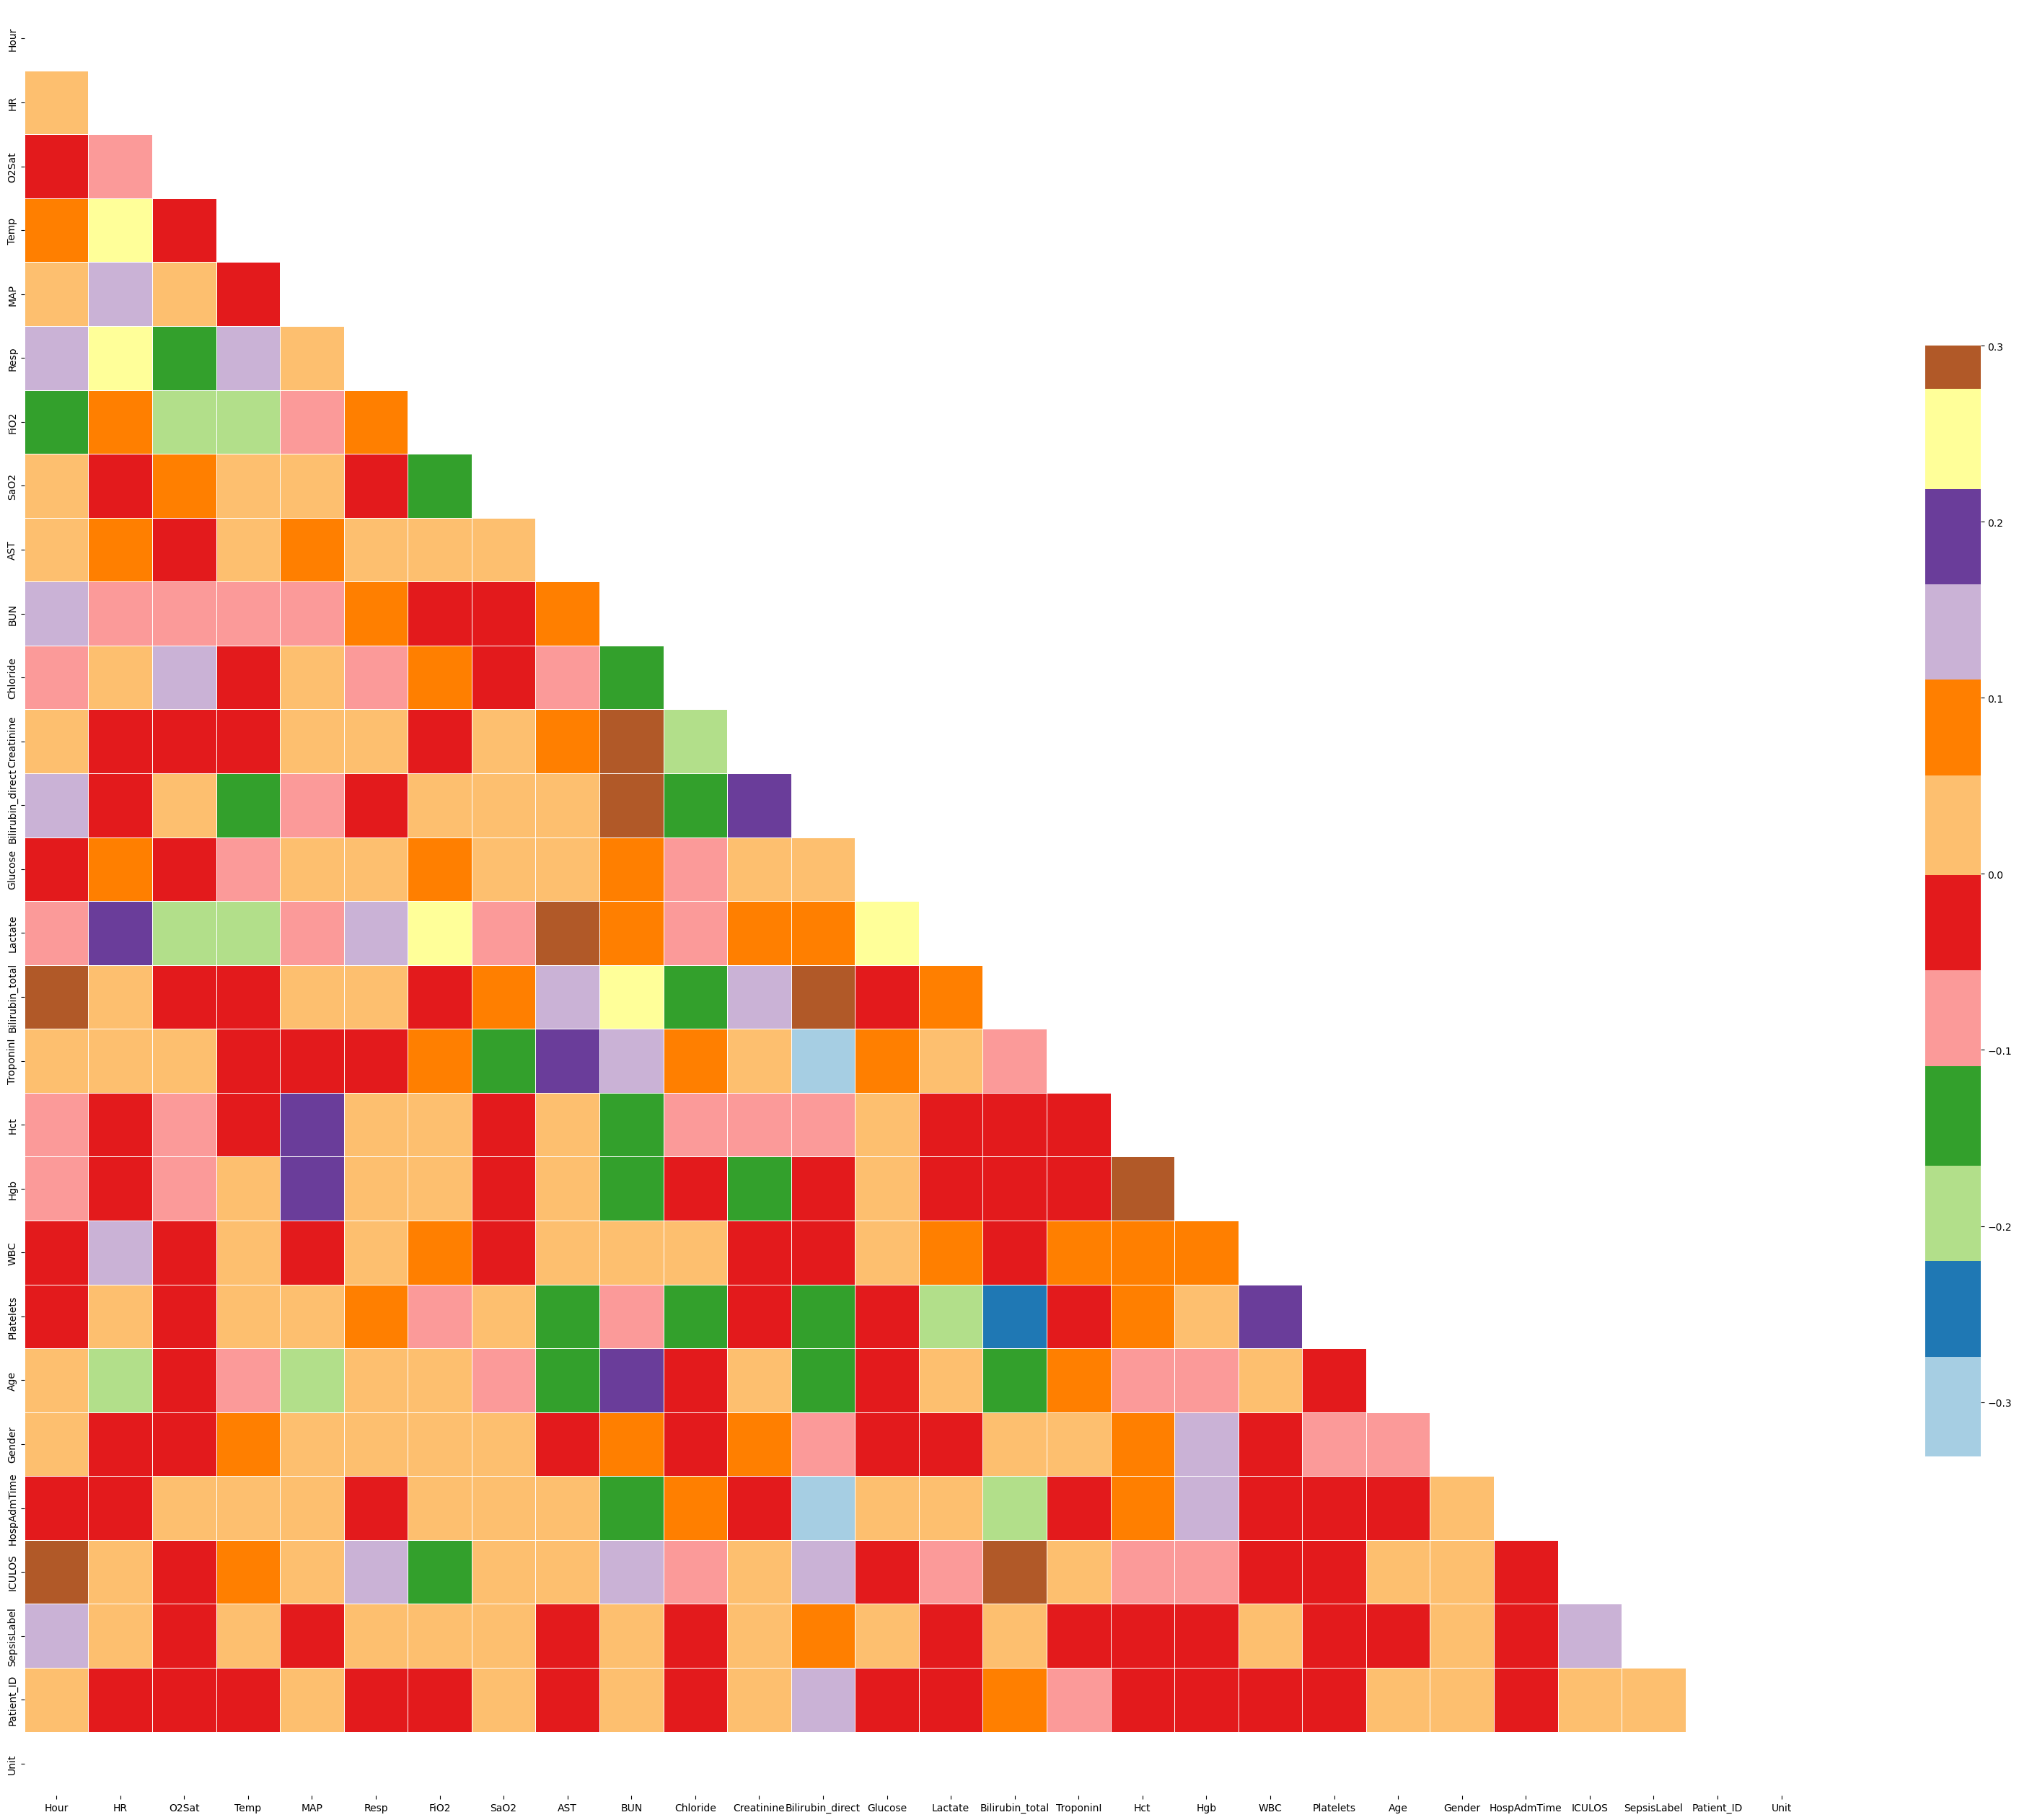

In [10]:
# correlation matrix to check if there is high correlation between the remaining features

corr_matrix(df_train_mod)

In [11]:
df_train_impute = df_train_mod.copy()
columns_impute = list(df_train_impute.columns)

In [12]:
# bfill and ffill for imputing

grouped_by_patient = df_train_impute.groupby('Patient_ID')
df_train_impute = grouped_by_patient.apply(lambda x: x.bfill().ffill())

/var/folders/4g/0ybq4ybd6n513hlrs2dc69d80000gn/T/ipykernel_3769/468124072.py:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_train_impute = grouped_by_patient.apply(lambda x: x.bfill().ffill())


In [13]:
df_train_impute.head()

,Hour,HR,O2Sat,Temp,MAP,Resp,FiO2,SaO2,AST,BUN,...,Hgb,WBC,Platelets,Age,Gender,HospAdmTime,ICULOS,SepsisLabel,Patient_ID,Unit
0,0,65.0,100.0,35.78,72.0,16.5,0.4,NaN,29.0,23.0,...,9.5,11.3,330.0,68.54,0,-0.02,1,0,17072,NaN
1,1,65.0,100.0,35.78,72.0,16.5,0.4,NaN,29.0,23.0,...,9.5,11.3,330.0,68.54,0,-0.02,2,0,17072,NaN
2,2,78.0,100.0,35.78,42.5,17.0,0.4,NaN,29.0,23.0,...,9.5,11.3,330.0,68.54,0,-0.02,3,0,17072,NaN
3,3,73.0,100.0,35.78,74.0,17.0,0.4,NaN,29.0,23.0,...,9.5,11.3,330.0,68.54,0,-0.02,4,0,17072,NaN
4,4,70.0,100.0,35.78,74.0,14.0,0.4,NaN,29.0,23.0,...,9.5,11.3,330.0,68.54,0,-0.02,5,0,17072,NaN


In [14]:
# Now let's check the remaining proportion of missing values

null_values = df_train_impute.isnull().mean()*100
null_values = null_values.sort_values(ascending=False)
null_values

TroponinI           97.357934
Bilirubin_direct    96.256841
Bilirubin_total     66.949754
AST                 66.435590
SaO2                57.282891
Lactate             55.997418
Unit                48.868346
FiO2                36.195592
WBC                  1.511994
Platelets            1.394810
Chloride             1.310656
Hgb                  1.158672
Creatinine           1.029467
Glucose              0.940630
BUN                  0.937719
Temp                 0.853692
Hct                  0.779028
Resp                 0.088710
O2Sat                0.026702
MAP                  0.003037
HR                   0.001139
HospAdmTime          0.001012
Age                  0.000000
Gender               0.000000
ICULOS               0.000000
SepsisLabel          0.000000
Patient_ID           0.000000
Hour                 0.000000
dtype: float64

In [15]:
# dropping all the columns with null values more than 25% and patient_id

null_col = ['TroponinI', 'Bilirubin_direct', 'AST', 'Bilirubin_total', 'Lactate', 'SaO2', 'FiO2',
            'Unit', 'Patient_ID']
df_train_impute = df_train_impute.drop(columns=null_col)
df_train_impute.columns

Index(['Hour', 'HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets', 'Age',
       'Gender', 'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

In [16]:
# onehot encoding the gender

one_hot = pd.get_dummies(df_train_impute['Gender'])
df_train_impute = df_train_impute.join(one_hot)
df_train_impute = df_train_impute.drop('Gender', axis=1)

In [17]:
# function to draw histogram and QQ plot 

def diagnostic_plots(df, variable):
    fig = plt.figure(figsize=(15,4))
    ax = fig.add_subplot(121)
    df[variable].hist(bins=30)
    ax = fig.add_subplot(122)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.xlabel(variable)
    plt.show()

In [18]:
# function to apply different transformations to make the plot gaussian

def try_gaussian(df, col):
  print('actual plot')
  diagnostic_plots(df,col)
  # this applies yeojohnson plot
  df['col_yj'], param = stats.yeojohnson(df[col]) 
  print('yeojohnson plot')
  diagnostic_plots(df, 'col_yj')
  # this applies exponential transformation
  df['col_1.5'] = df[col]**(1/1.5)
  print('**1/1.5 plot') 
  diagnostic_plots(df, 'col_1.5')
  df['col_.5'] = df[col]**(.5)
  print('**.5 plot') 
  # this applies inverse transformation
  diagnostic_plots(df, 'col_.5')
  df['col_rec'] = 1 / (df[col]+0.00001) 
  diagnostic_plots(df, 'col_rec')
  # this applies logarithmic trasnformation
  df['col_log'] = np.log(df[col]+1)
  diagnostic_plots(df, 'col_log')   

O2Sat
actual plot


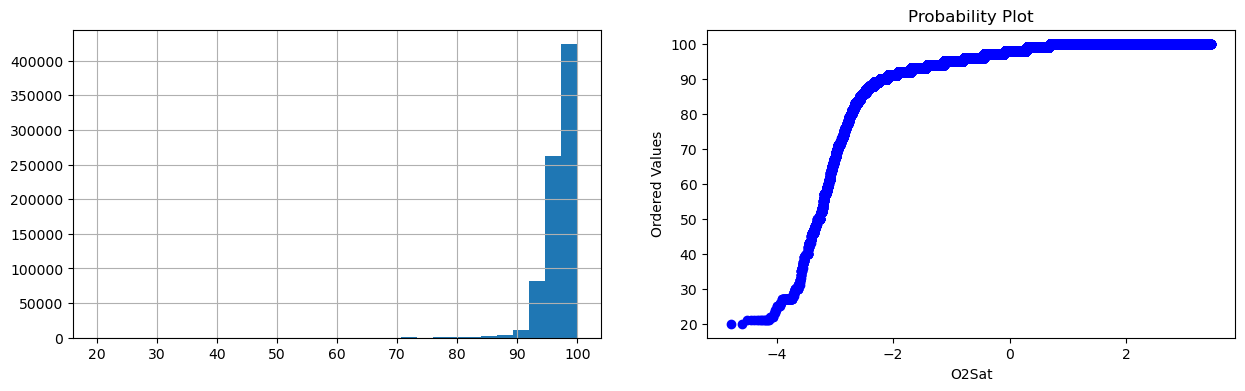

yeojohnson plot


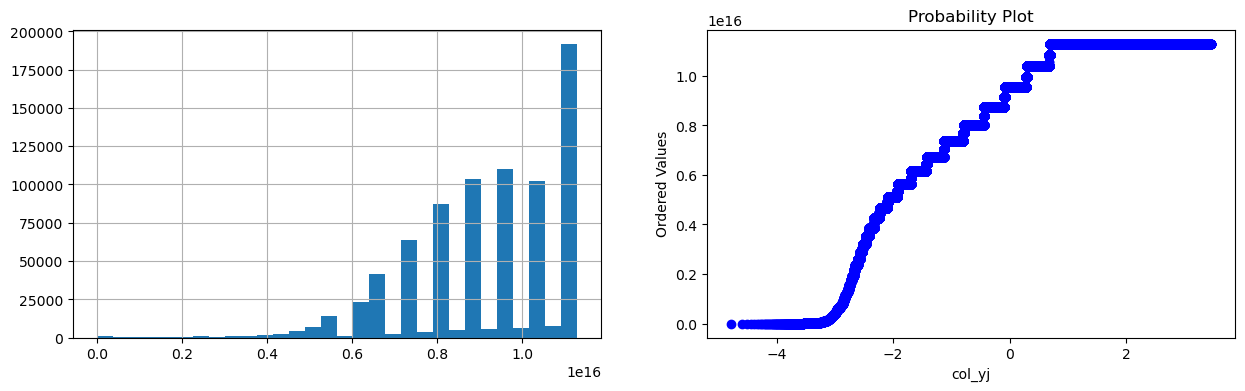

**1/1.5 plot


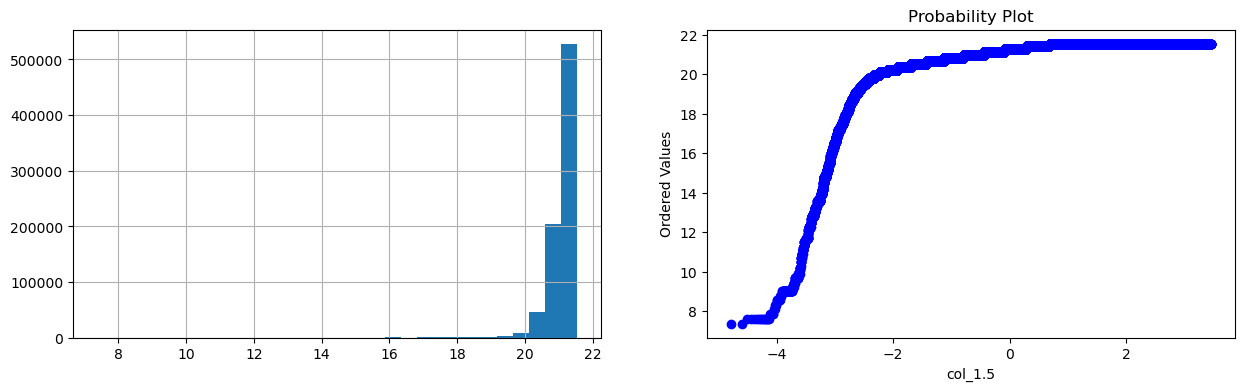

**.5 plot


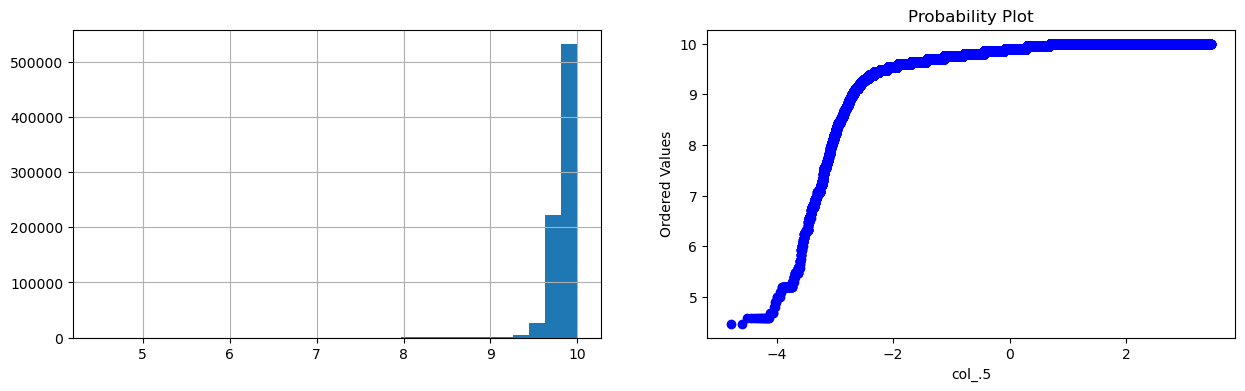

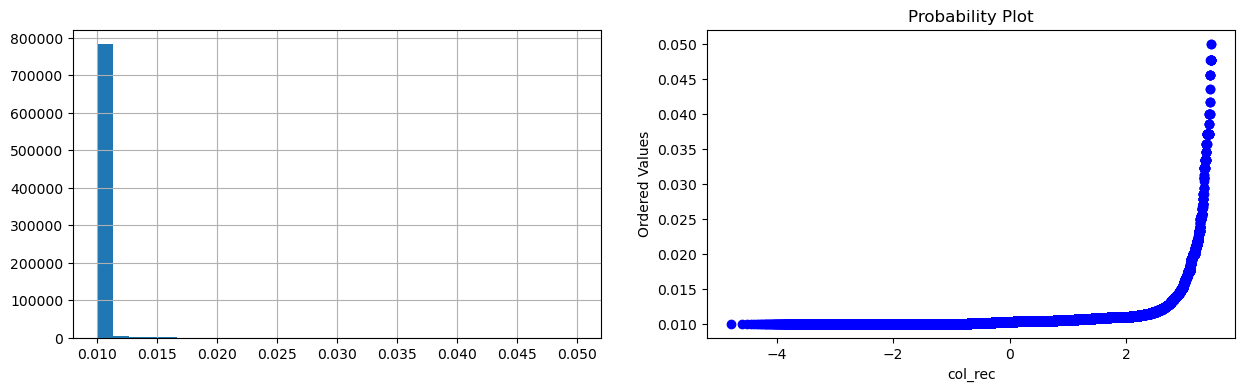

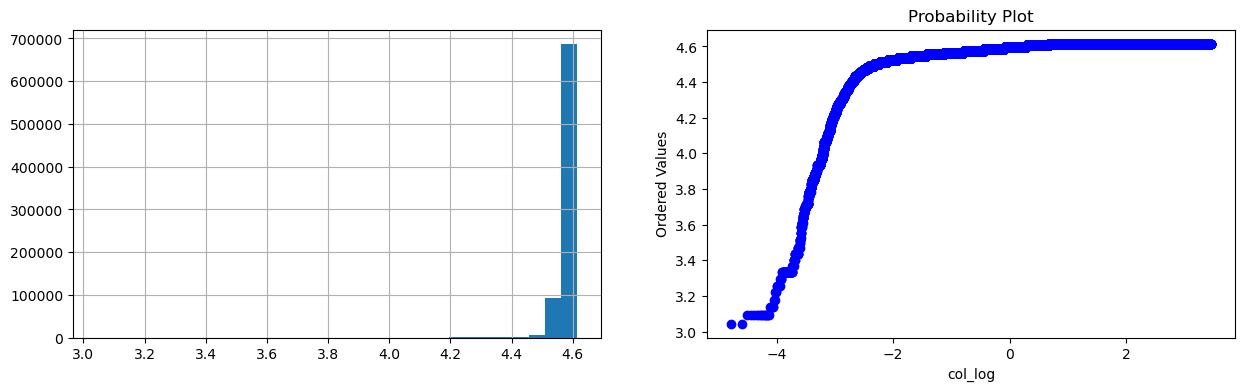

Temp
actual plot


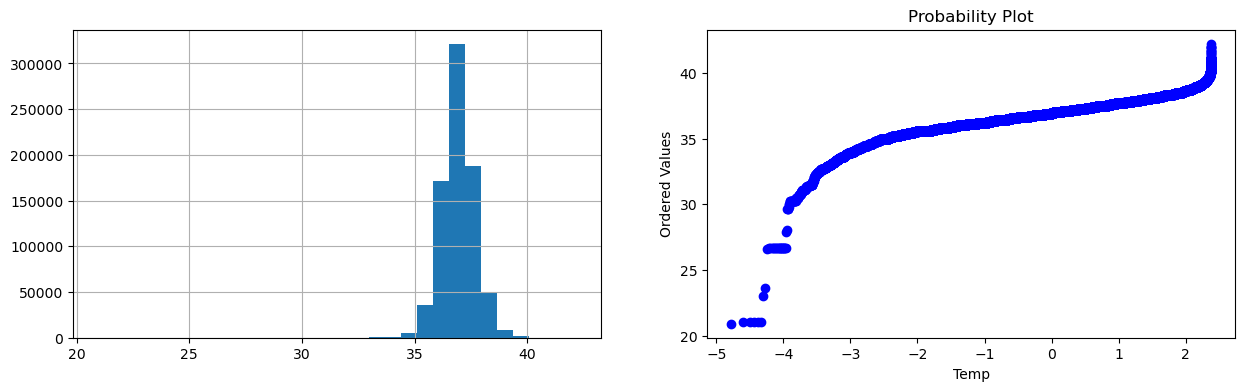

yeojohnson plot


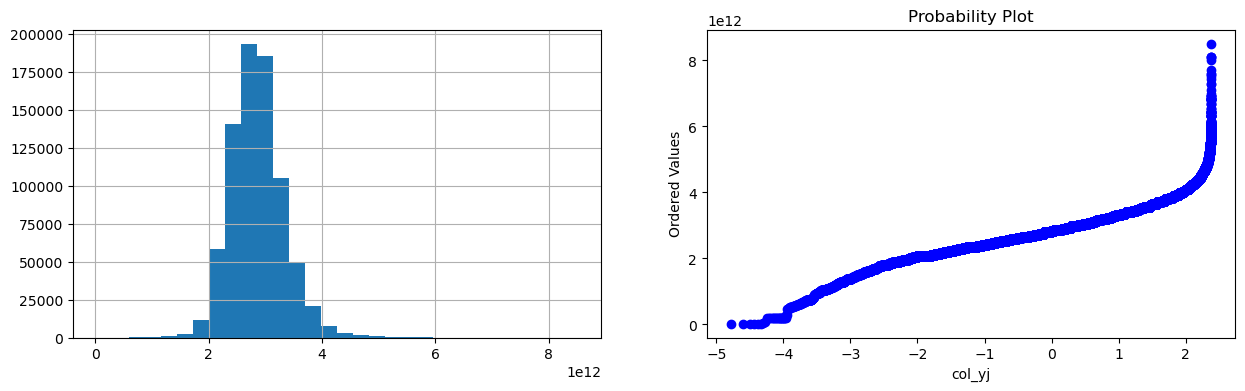

**1/1.5 plot


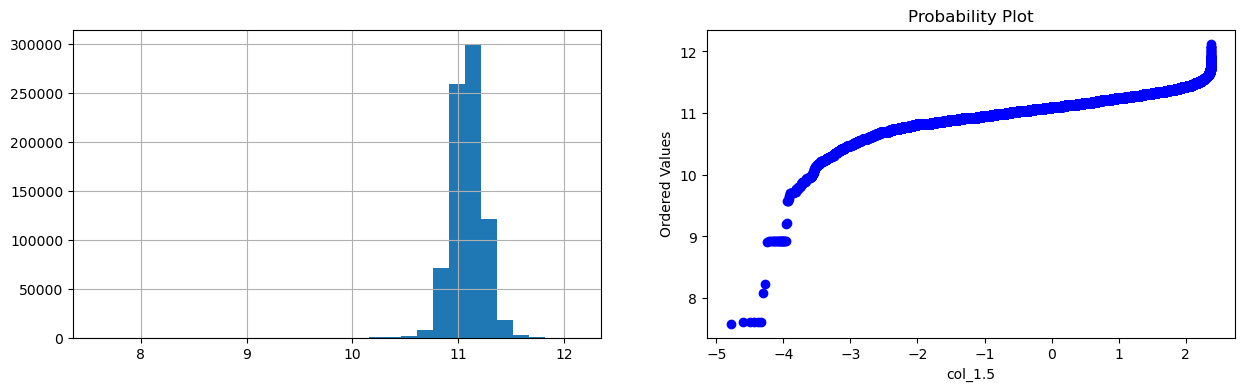

**.5 plot


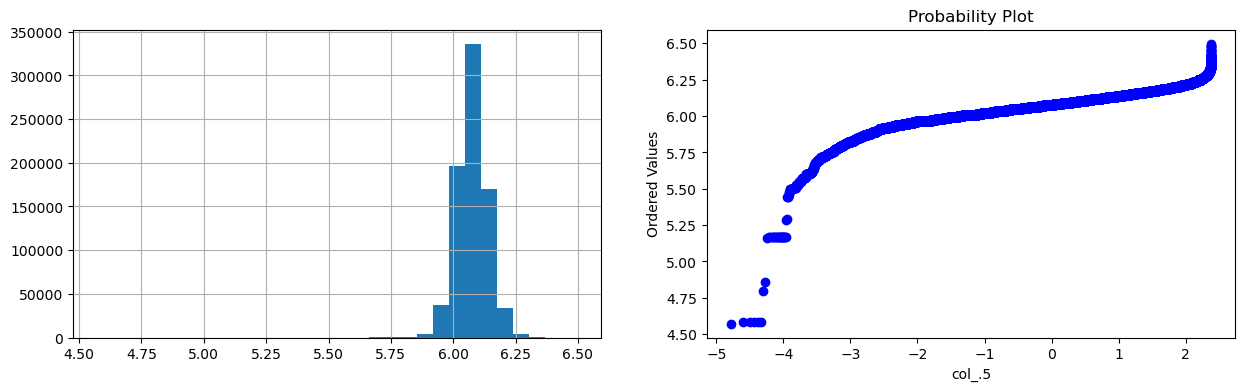

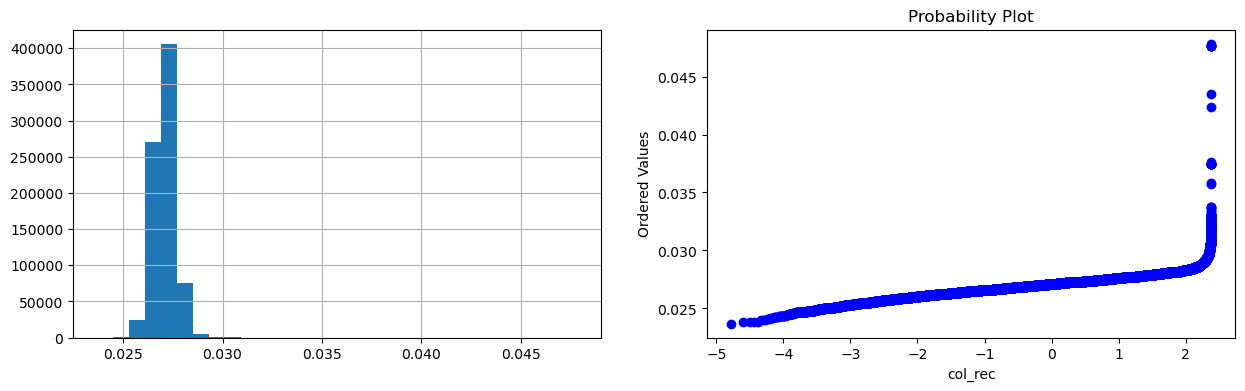

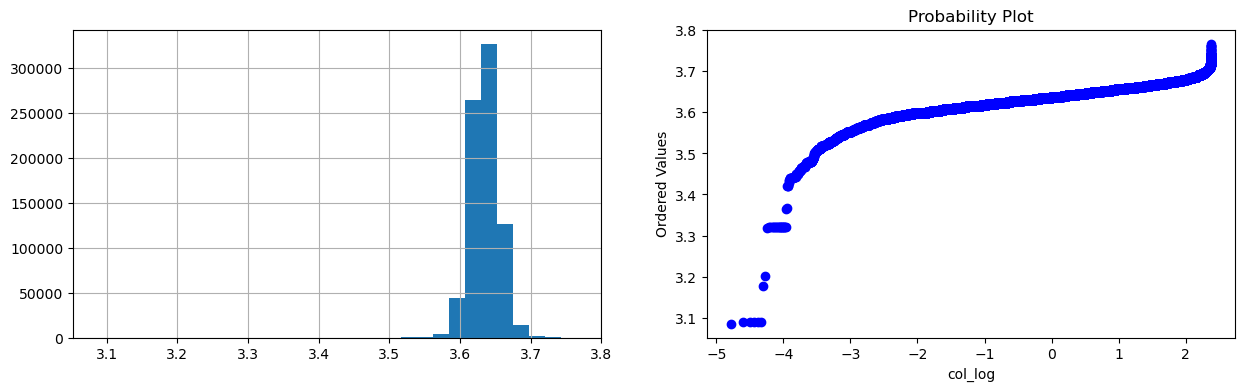

MAP
actual plot


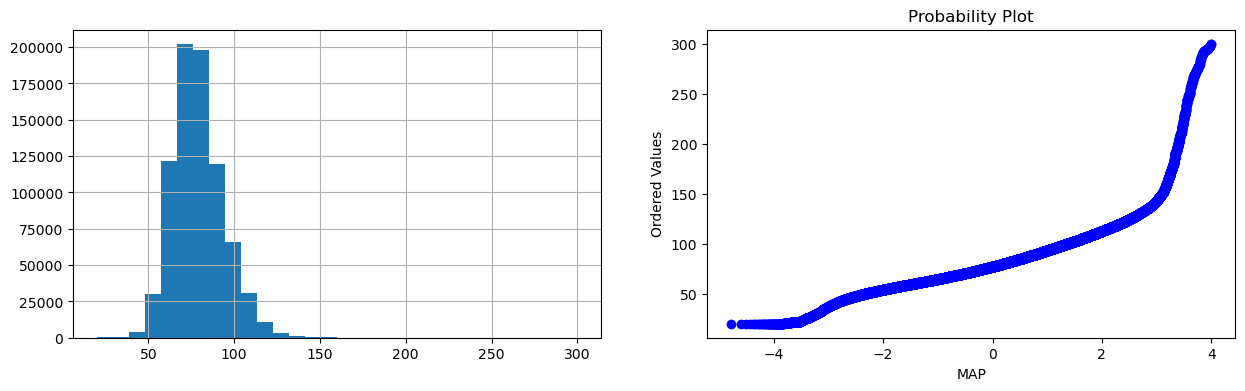

yeojohnson plot


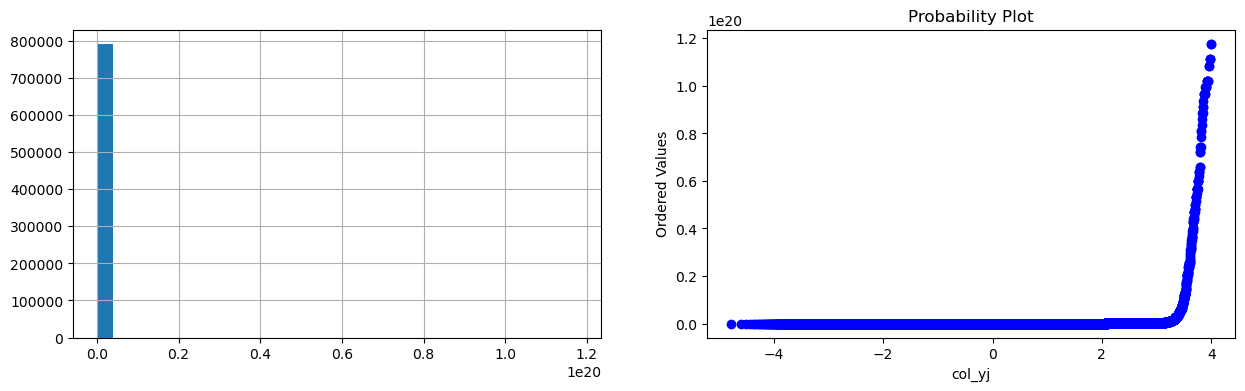

**1/1.5 plot


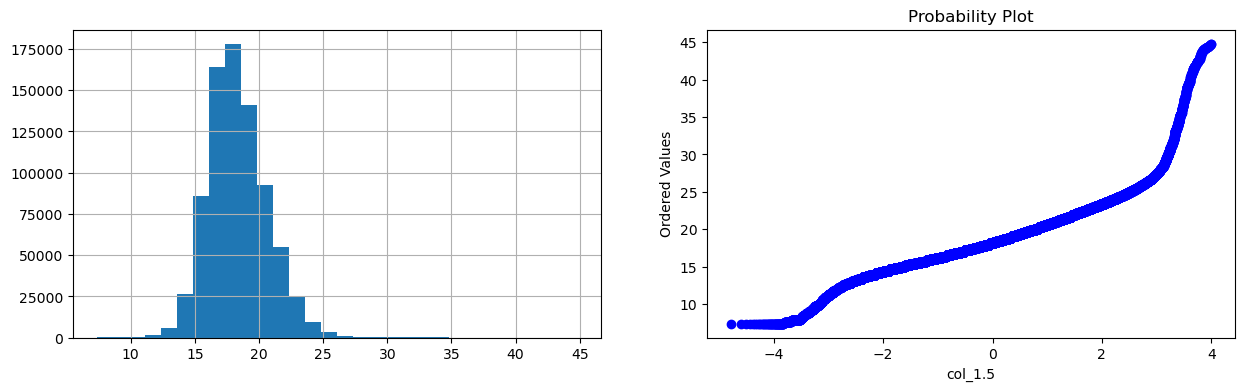

**.5 plot


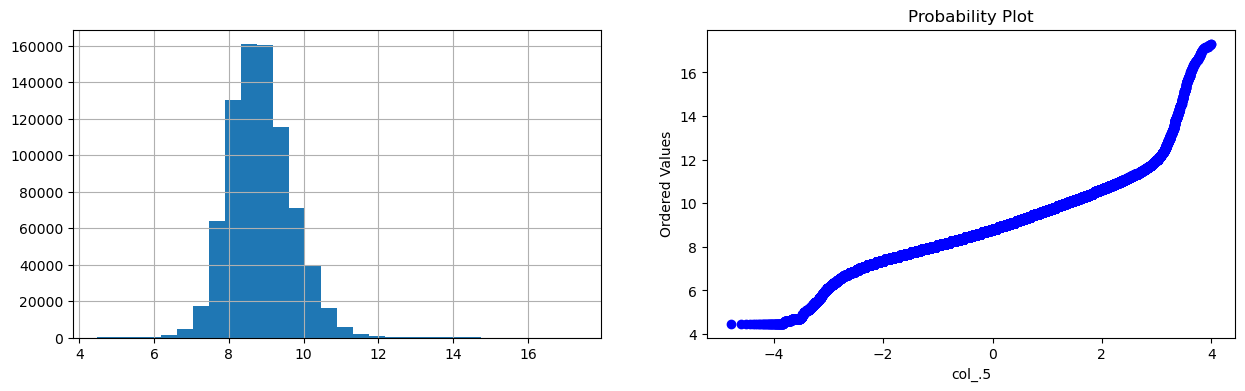

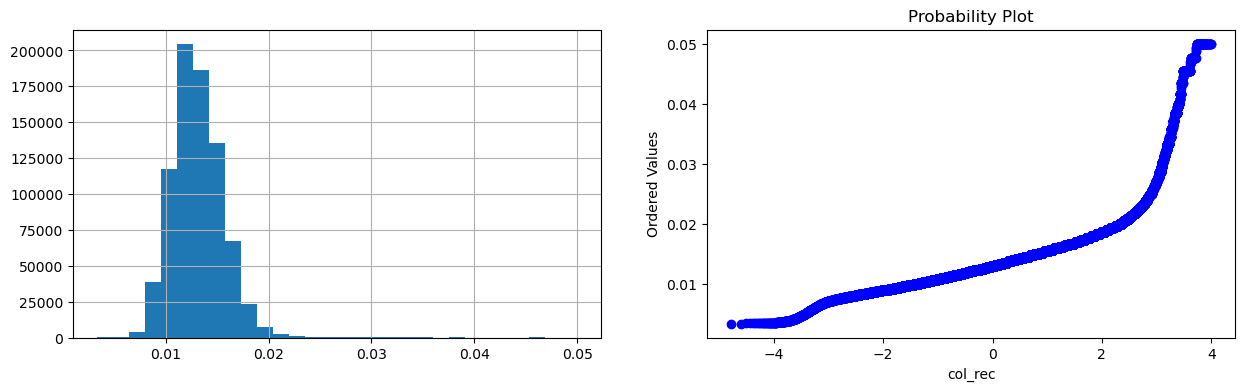

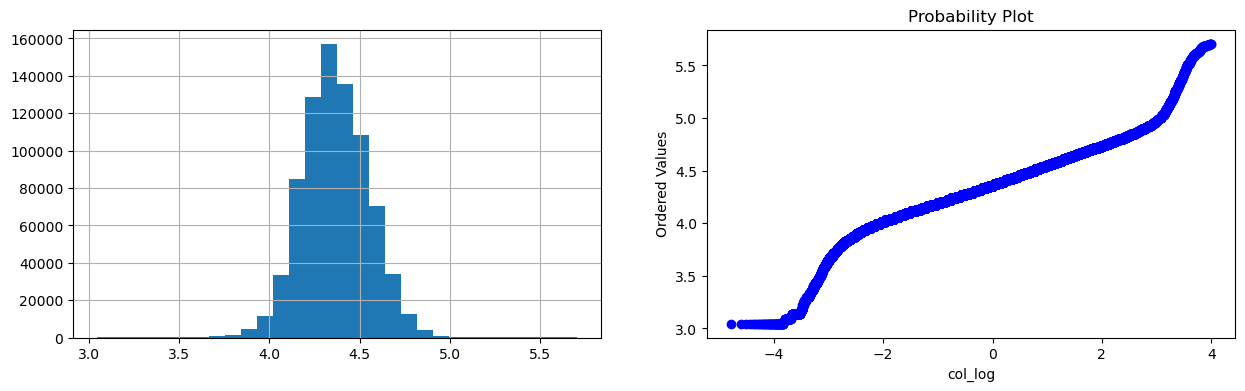

BUN
actual plot


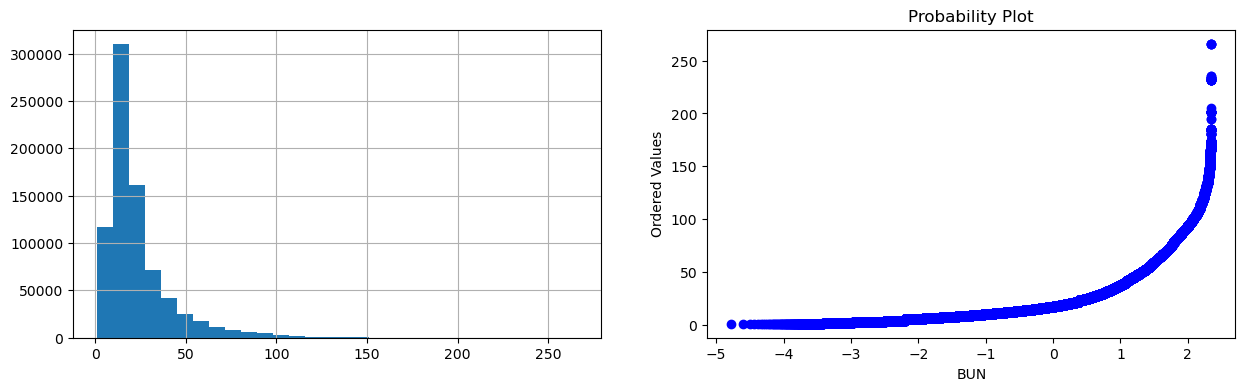

yeojohnson plot


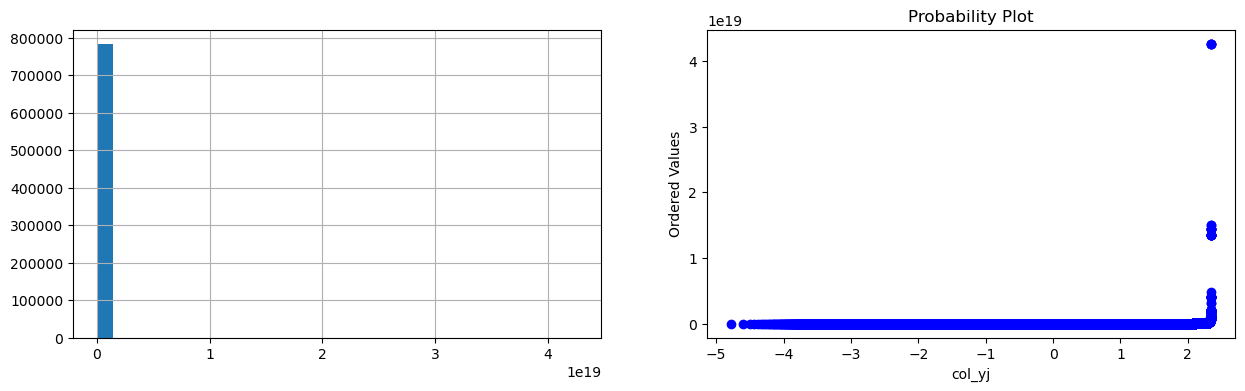

**1/1.5 plot


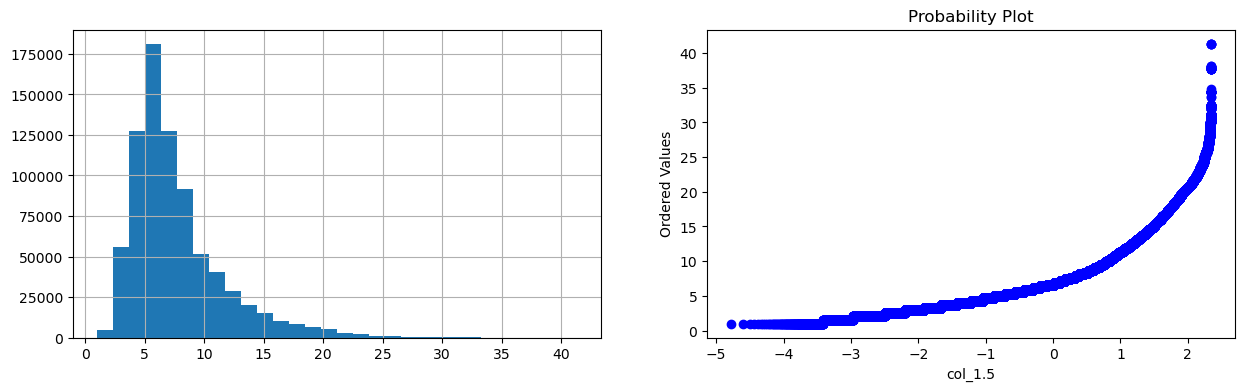

**.5 plot


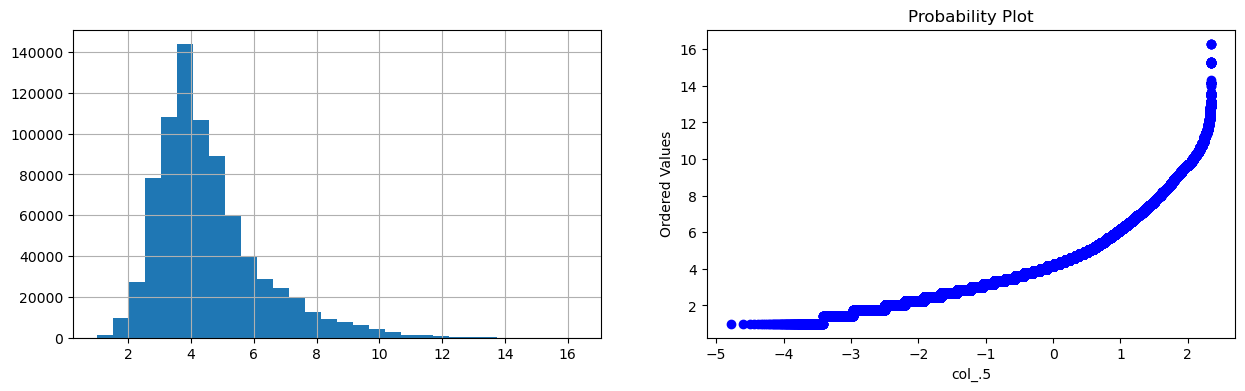

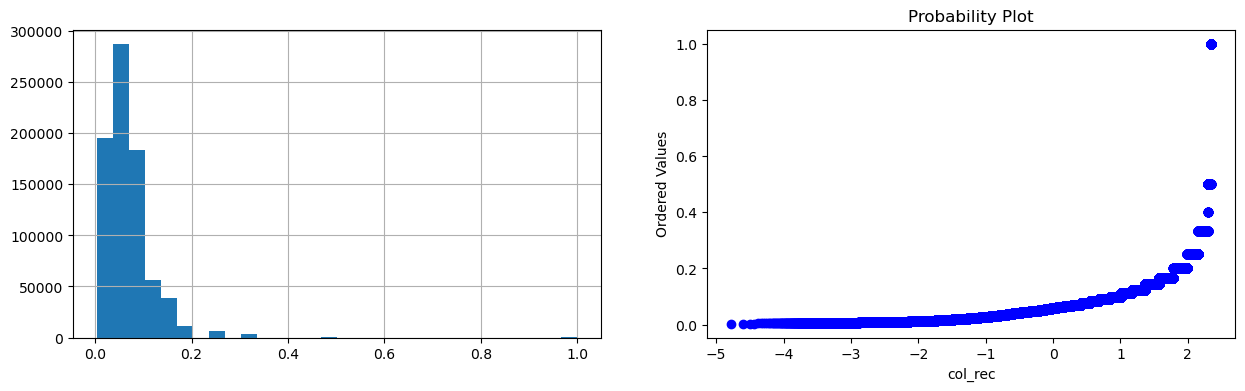

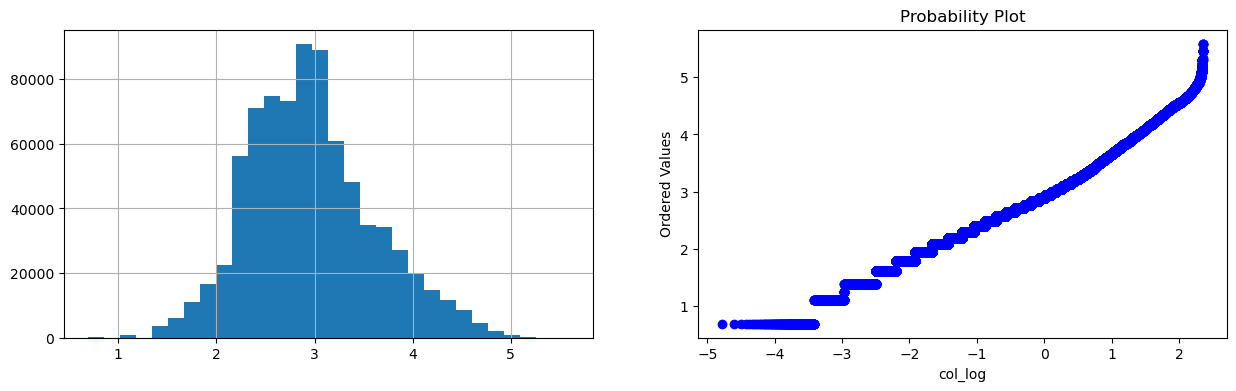

Creatinine
actual plot


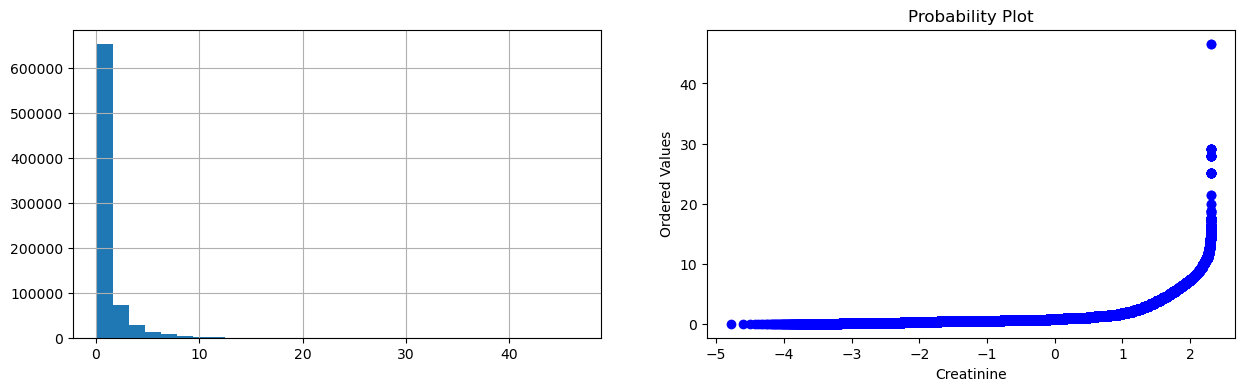

yeojohnson plot


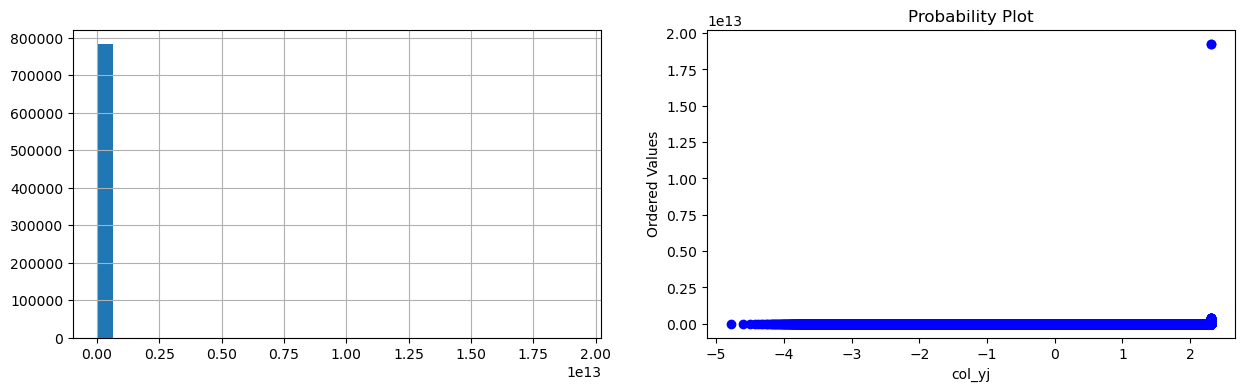

**1/1.5 plot


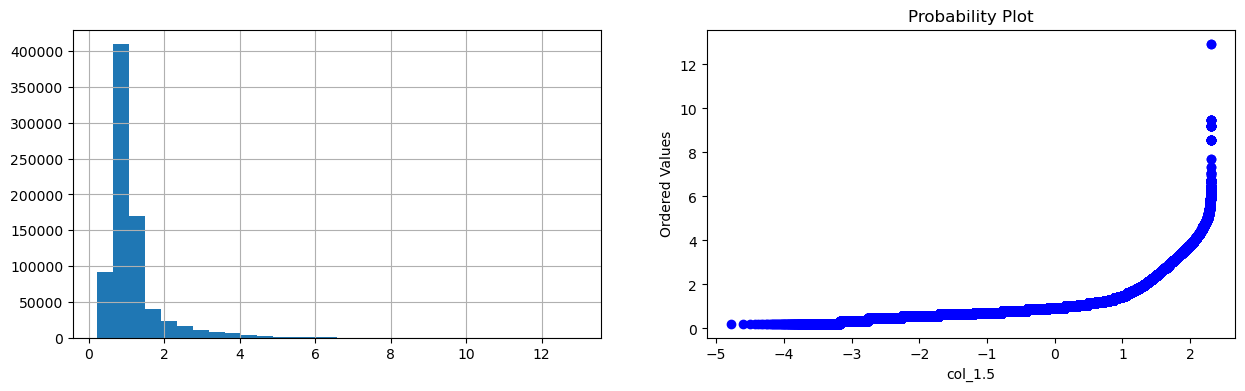

**.5 plot


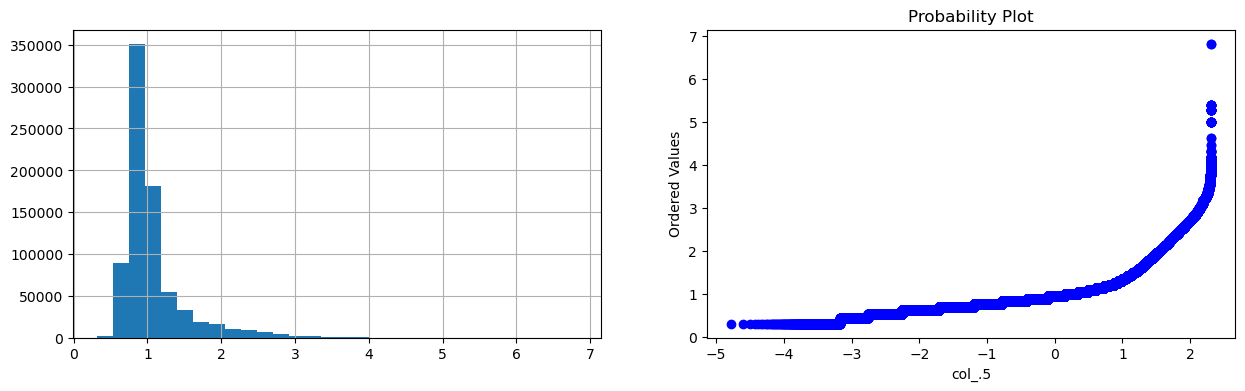

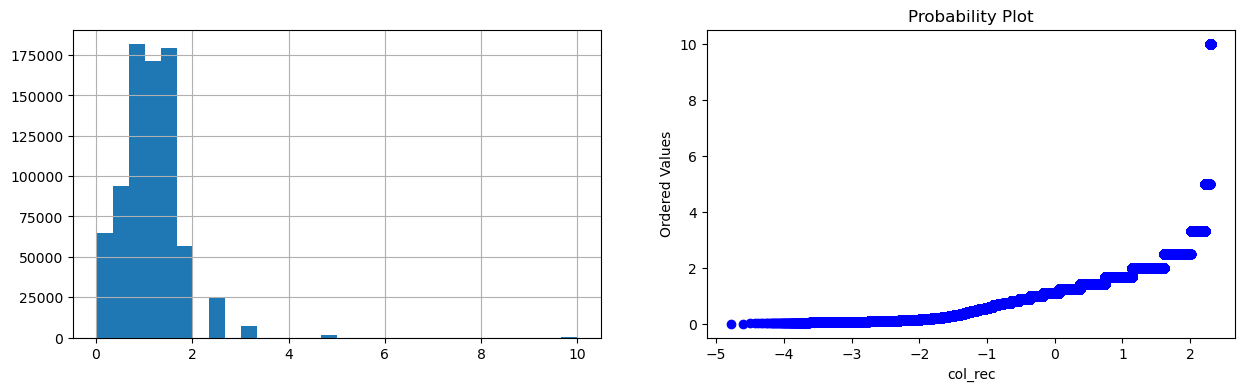

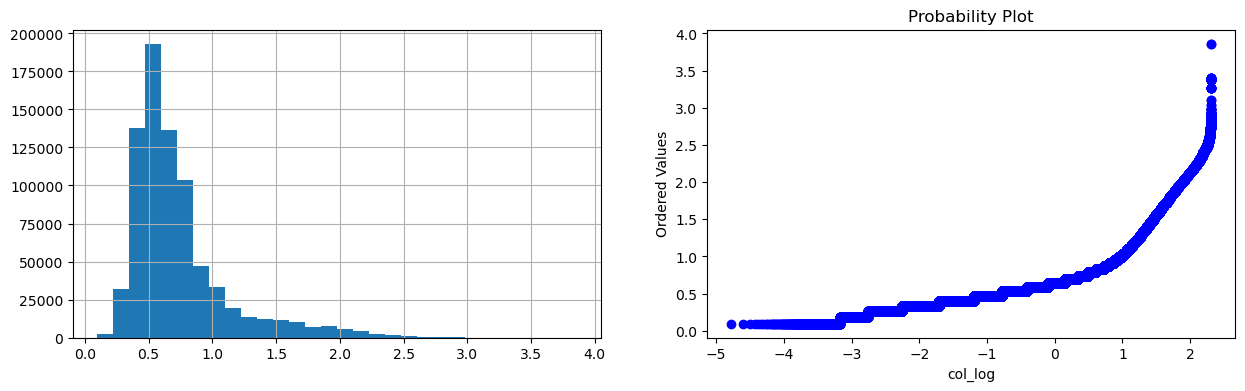

Glucose
actual plot


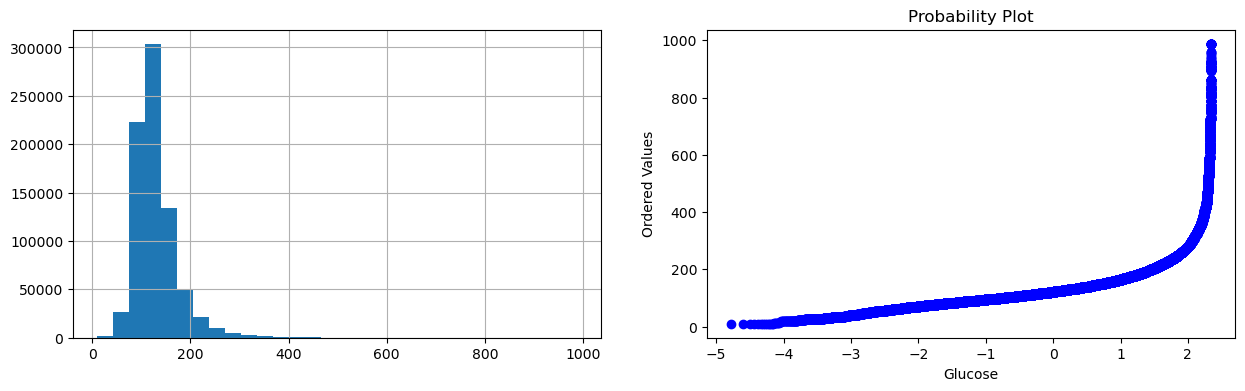

yeojohnson plot


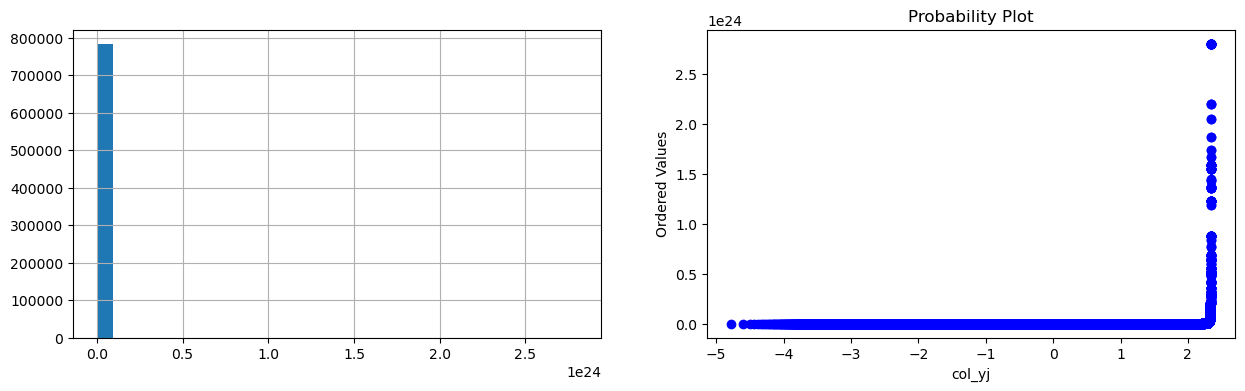

**1/1.5 plot


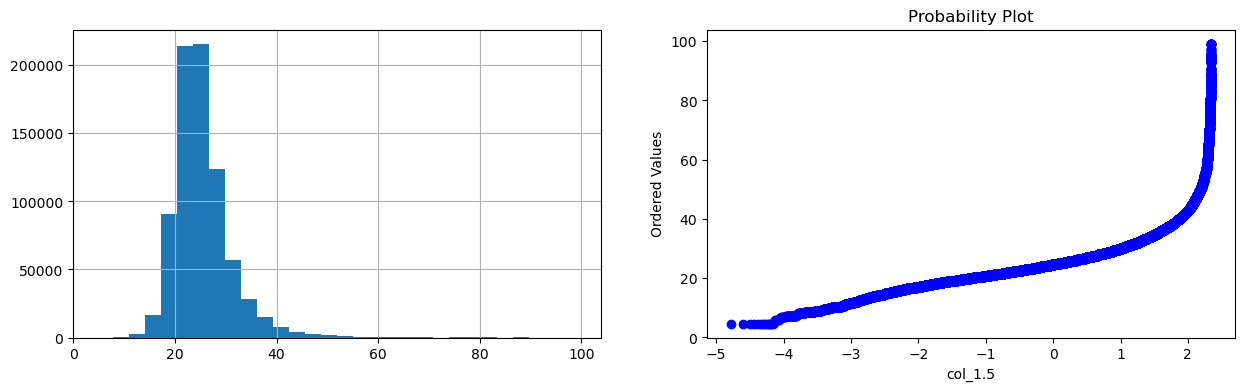

**.5 plot


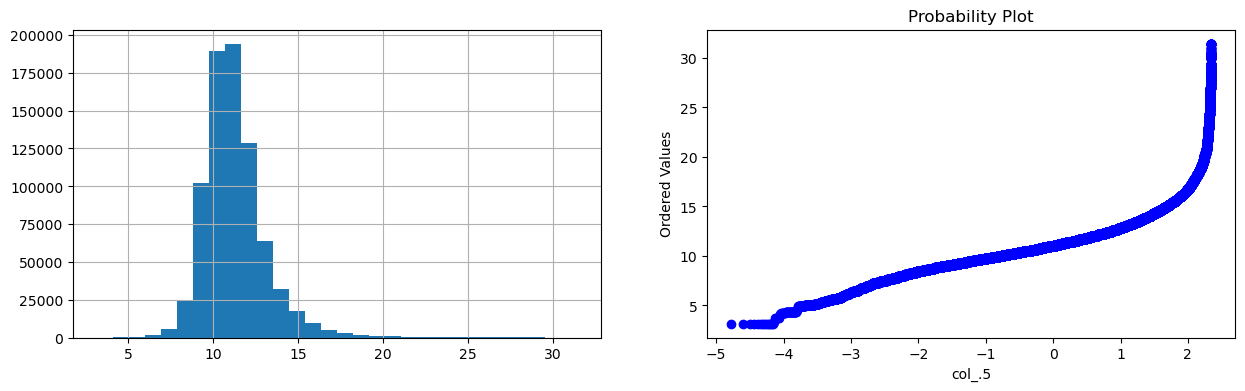

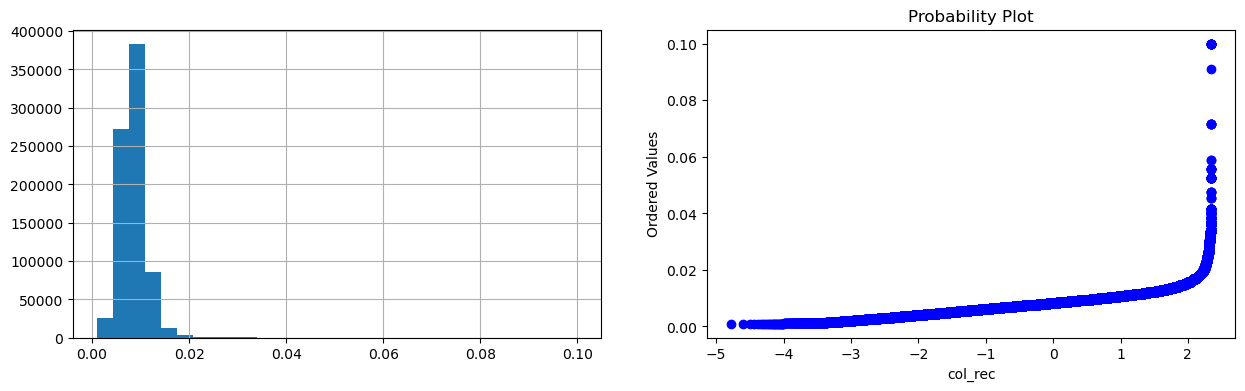

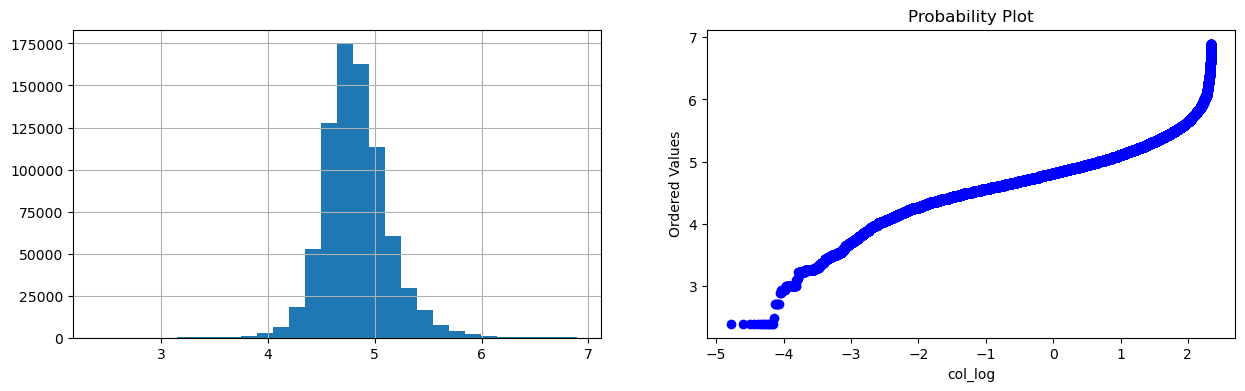

WBC
actual plot


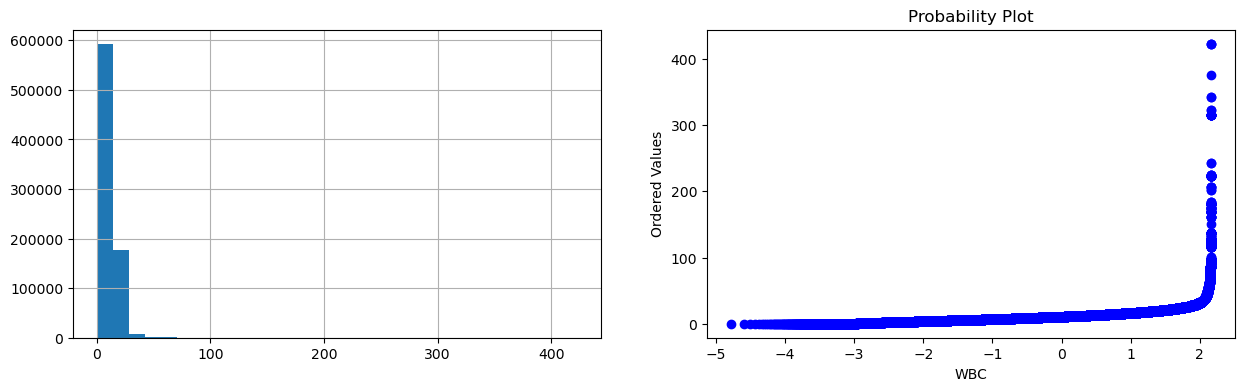

yeojohnson plot


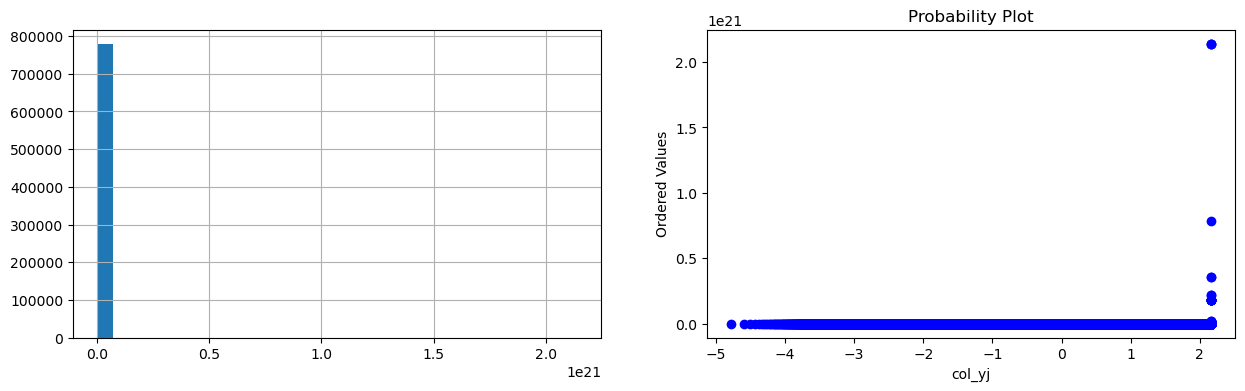

**1/1.5 plot


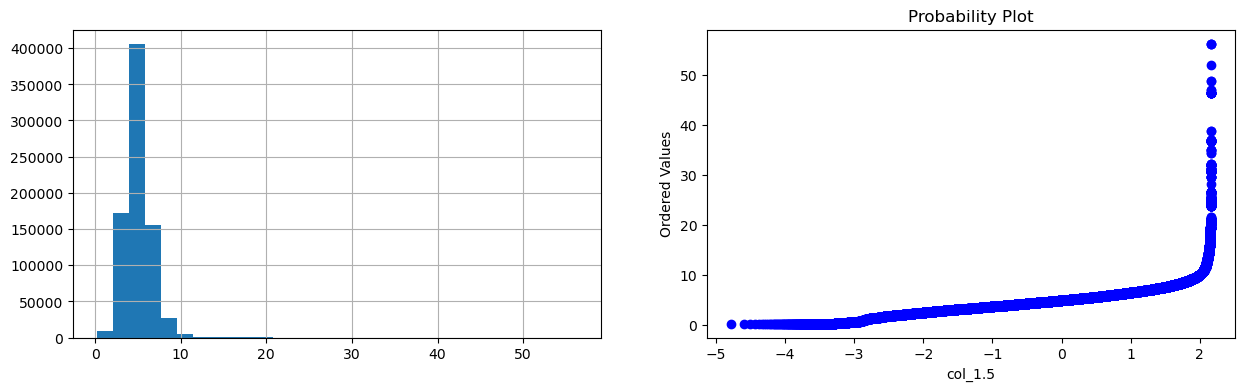

**.5 plot


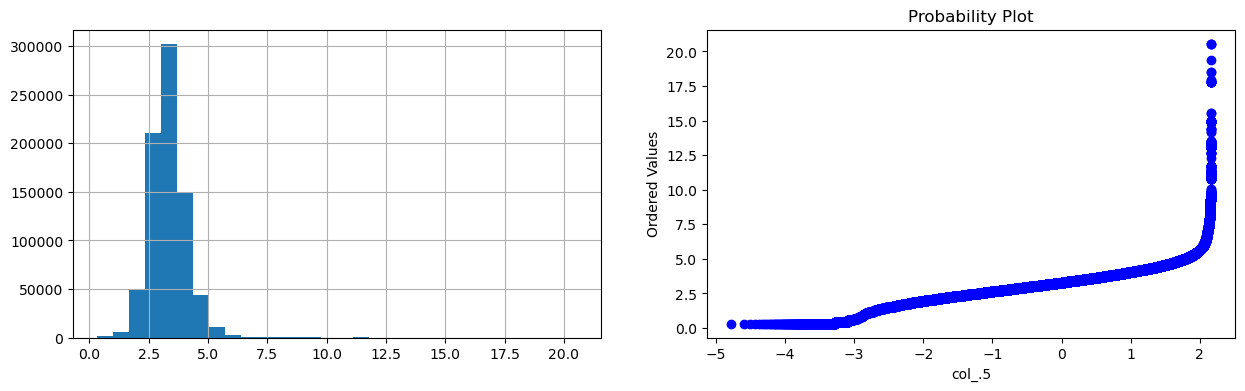

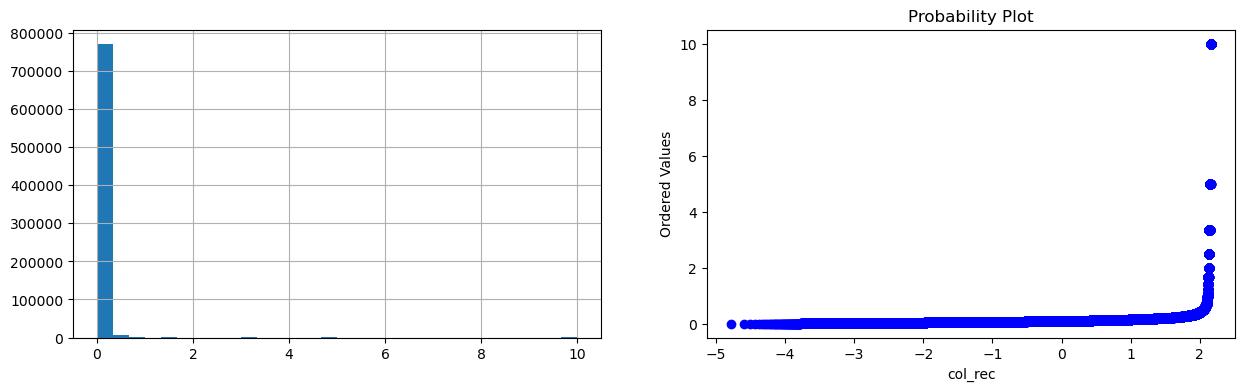

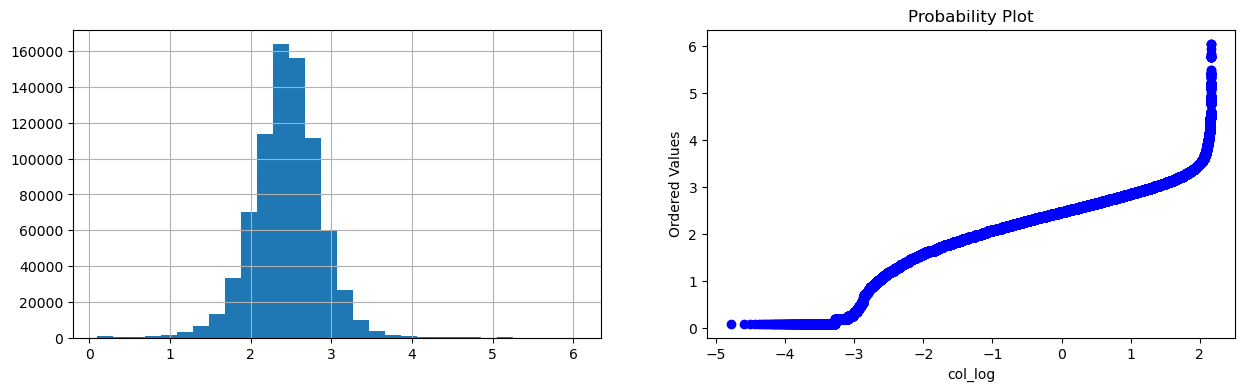

Platelets
actual plot


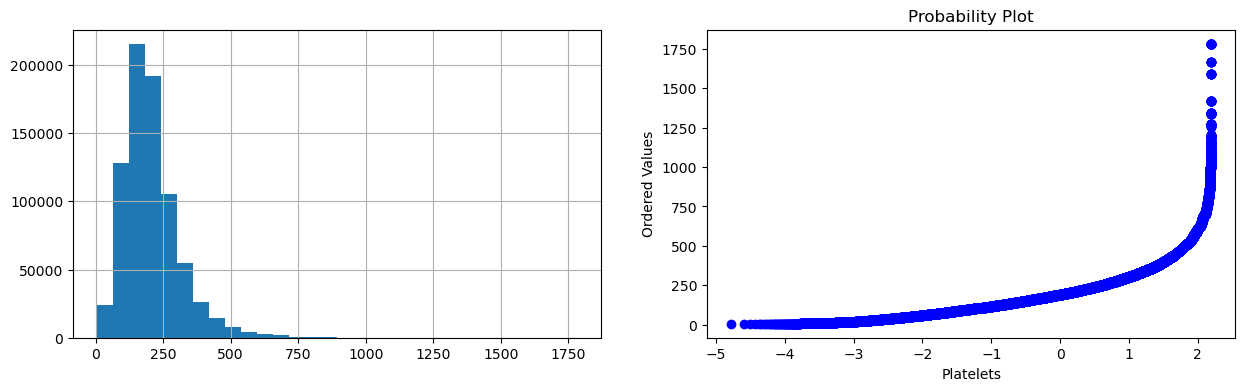

yeojohnson plot


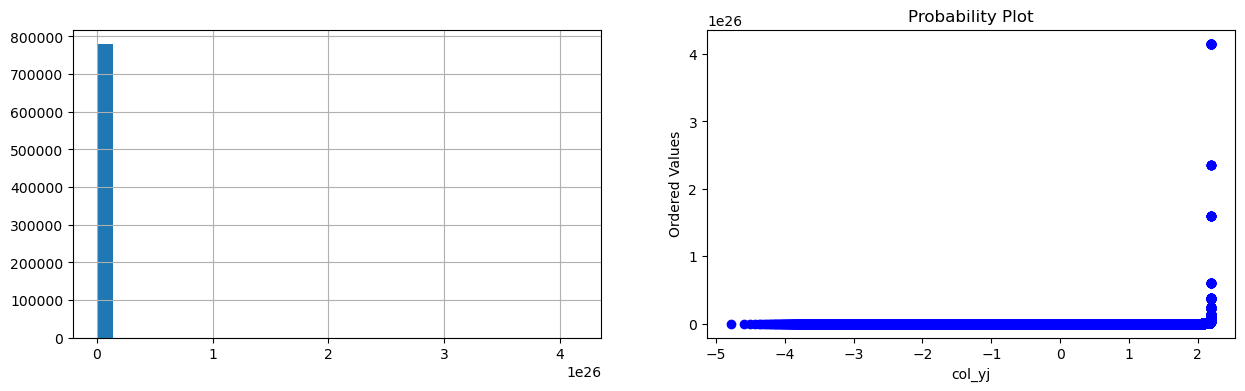

**1/1.5 plot


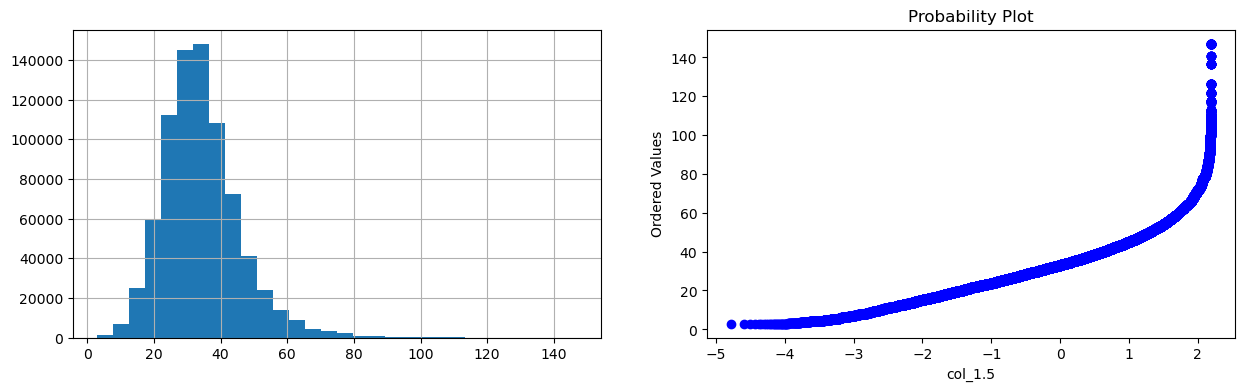

**.5 plot


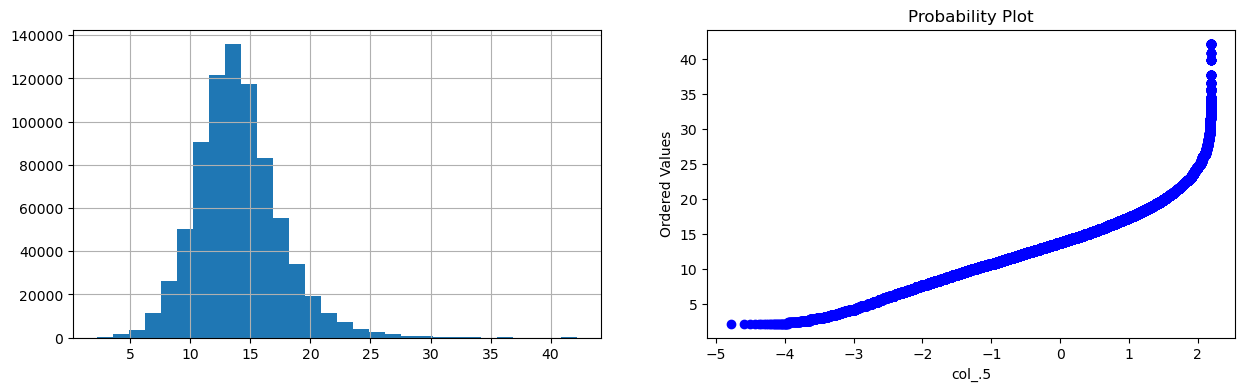

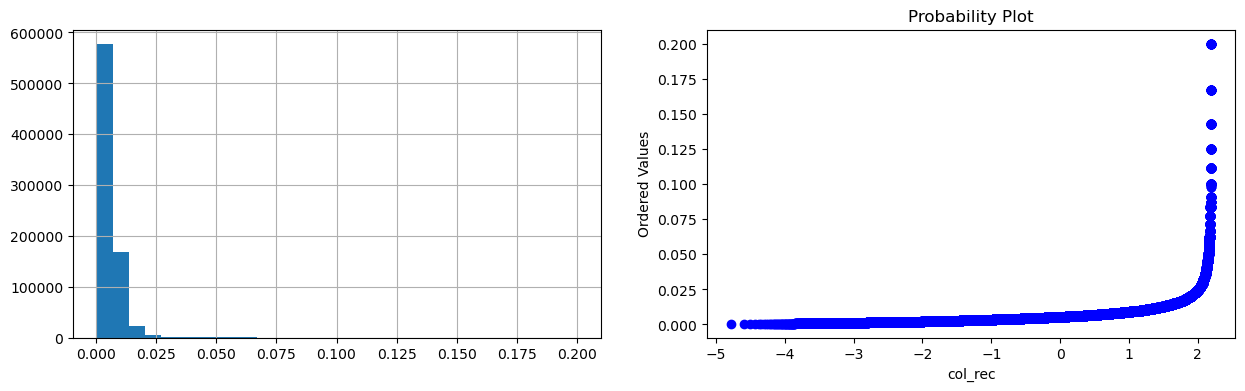

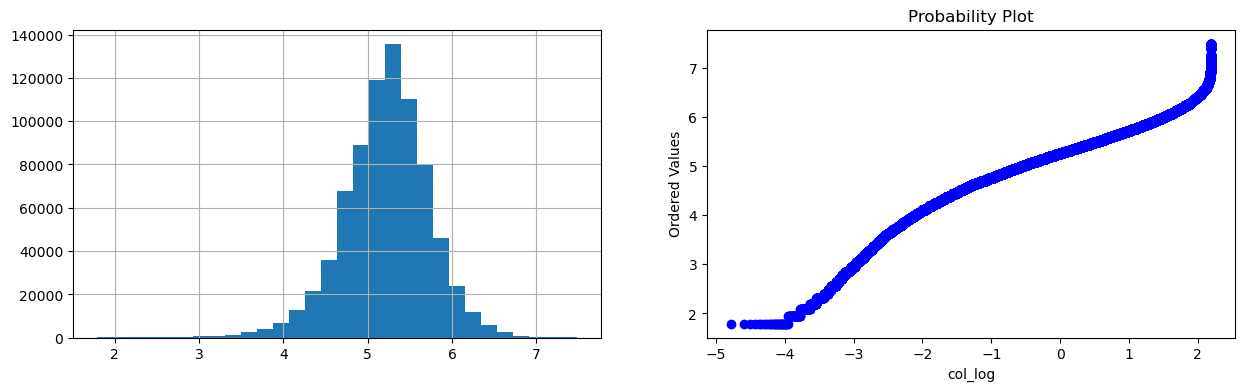

In [19]:
#try normal distribution
#Now we try to check the distribution of values present in different columns after application of various transformations


lst = ['O2Sat', 'Temp', 'MAP', 'BUN', 'Creatinine', 'Glucose', 'WBC', 'Platelets' ]
for i in lst:
  print(i)
  try_gaussian(df_train_impute, i)

In [20]:
#after application of the above code, some redundant columns got added to the dataframe, which are removed below

df_train_impute = df_train_impute.drop(columns = ['col_yj','col_1.5','col_.5','col_rec','col_log'])

In [21]:
df_train_impute.head()

,Hour,HR,O2Sat,Temp,MAP,Resp,BUN,Chloride,Creatinine,Glucose,Hct,Hgb,WBC,Platelets,Age,HospAdmTime,ICULOS,SepsisLabel,0,1
0,0,65.0,100.0,35.78,72.0,16.5,23.0,104.0,0.8,161.0,29.7,9.5,11.3,330.0,68.54,-0.02,1,0,1,0
1,1,65.0,100.0,35.78,72.0,16.5,23.0,104.0,0.8,161.0,29.7,9.5,11.3,330.0,68.54,-0.02,2,0,1,0
2,2,78.0,100.0,35.78,42.5,17.0,23.0,104.0,0.8,161.0,29.7,9.5,11.3,330.0,68.54,-0.02,3,0,1,0
3,3,73.0,100.0,35.78,74.0,17.0,23.0,104.0,0.8,161.0,29.7,9.5,11.3,330.0,68.54,-0.02,4,0,1,0
4,4,70.0,100.0,35.78,74.0,14.0,23.0,104.0,0.8,161.0,29.7,9.5,11.3,330.0,68.54,-0.02,5,0,1,0


In [22]:
# by oserving different plots, it can be concluded that only log was somewhat effective and that too for MAP, BUN, Creatinine, Glucose, WBC & Plateletes
# therefore applying log transformations on the above columns

columns_normalized = ['MAP', 'BUN', 'Creatinine', 'Glucose', 'WBC', 'Platelets' ]
for i in columns_normalized:
  df_train_impute[i] = np.log(df_train_impute[i]+1)

In [23]:
df_train_impute.head()

,Hour,HR,O2Sat,Temp,MAP,Resp,BUN,Chloride,Creatinine,Glucose,Hct,Hgb,WBC,Platelets,Age,HospAdmTime,ICULOS,SepsisLabel,0,1
0,0,65.0,100.0,35.78,4.290459,16.5,3.178054,104.0,0.587787,5.087596,29.7,9.5,2.509599,5.802118,68.54,-0.02,1,0,1,0
1,1,65.0,100.0,35.78,4.290459,16.5,3.178054,104.0,0.587787,5.087596,29.7,9.5,2.509599,5.802118,68.54,-0.02,2,0,1,0
2,2,78.0,100.0,35.78,3.772761,17.0,3.178054,104.0,0.587787,5.087596,29.7,9.5,2.509599,5.802118,68.54,-0.02,3,0,1,0
3,3,73.0,100.0,35.78,4.317488,17.0,3.178054,104.0,0.587787,5.087596,29.7,9.5,2.509599,5.802118,68.54,-0.02,4,0,1,0
4,4,70.0,100.0,35.78,4.317488,14.0,3.178054,104.0,0.587787,5.087596,29.7,9.5,2.509599,5.802118,68.54,-0.02,5,0,1,0


In [24]:
# standard normalization

scaler = StandardScaler()
df_train_impute[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']] = scaler.fit_transform(df_train_impute[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']])
df_train_impute.head()

,Hour,HR,O2Sat,Temp,MAP,Resp,BUN,Chloride,Creatinine,Glucose,Hct,Hgb,WBC,Platelets,Age,HospAdmTime,ICULOS,SepsisLabel,0,1
0,0,-1.170030,0.865243,-1.548869,-0.397650,-0.419685,0.322965,-0.226541,-0.410796,0.854631,-0.311111,-0.652538,0.149678,1.140763,68.54,-0.02,1,0,1,0
1,1,-1.170030,0.865243,-1.548869,-0.397650,-0.419685,0.322965,-0.226541,-0.410796,0.854631,-0.311111,-0.652538,0.149678,1.140763,68.54,-0.02,2,0,1,0
2,2,-0.407913,0.865243,-1.548869,-3.187955,-0.326969,0.322965,-0.226541,-0.410796,0.854631,-0.311111,-0.652538,0.149678,1.140763,68.54,-0.02,3,0,1,0
3,3,-0.701035,0.865243,-1.548869,-0.251970,-0.326969,0.322965,-0.226541,-0.410796,0.854631,-0.311111,-0.652538,0.149678,1.140763,68.54,-0.02,4,0,1,0
4,4,-0.876908,0.865243,-1.548869,-0.251970,-0.883265,0.322965,-0.226541,-0.410796,0.854631,-0.311111,-0.652538,0.149678,1.140763,68.54,-0.02,5,0,1,0


In [25]:
df_train_impute = df_train_impute.dropna()

In [26]:
null_values = df_train_impute.isnull().mean()*100
null_values

Hour           0.0
HR             0.0
O2Sat          0.0
Temp           0.0
MAP            0.0
Resp           0.0
BUN            0.0
Chloride       0.0
Creatinine     0.0
Glucose        0.0
Hct            0.0
Hgb            0.0
WBC            0.0
Platelets      0.0
Age            0.0
HospAdmTime    0.0
ICULOS         0.0
SepsisLabel    0.0
0              0.0
1              0.0
dtype: float64

In [27]:
# this function will transform the dataframe (for final testing) in the compatible 
# format for the input of the model
# this will make it easier to get the dataframe ready in a single go for prediction

def get_data_ready(df):
  columns_drop={'Unnamed: 0','SBP','DBP','EtCO2','BaseExcess', 'HCO3','pH','PaCO2','Alkalinephos', 'Calcium','Magnesium', 
  'Phosphate','Potassium','PTT','Fibrinogen','Unit1','Unit2'}
  df = df.assign(Unit=df['Unit1'] + df['Unit2'])
  # dropping columns based on redundancy
  df = df.drop(columns=columns_drop)
  grouped_by_patient = df.groupby('Patient_ID')
  # imputing backfill and forward fill
  df = grouped_by_patient.apply(lambda x: x.bfill().ffill())
  # dropping all the columns with null values more than 25% and patient_id
  null_col = ['TroponinI', 'Bilirubin_direct', 'AST', 'Bilirubin_total', 'Lactate', 'SaO2', 'FiO2','Unit', 'Patient_ID']
  df = df.drop(columns=null_col)
  # gaussian transformation
  columns_normalized = ['MAP', 'BUN', 'Creatinine', 'Glucose', 'WBC', 'Platelets' ]
  for i in columns_normalized:
    df[i] = np.log(df[i]+1)
  # normailizing
  scaler = StandardScaler()
  df[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']] = scaler.fit_transform(df[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']])
  # onehot encoding the gender
  one_hot = pd.get_dummies(df['Gender'])
  df = df.join(one_hot)
  df = df.drop('Gender', axis=1)
  df = df.dropna()
  return df

In [28]:
# this fucntion calculates different evaluation parameters of a model


def evaluate_model(y_true,y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  print("Accuracy:", accuracy)
  precision = precision_score(y_true, y_pred)
  print("Precision:", precision)
  recall = recall_score(y_true, y_pred)
  print("Recall:", recall)
  f1 = f1_score(y_true, y_pred)
  print("F1 Score:", f1)
  auc = roc_auc_score(y_true, y_pred)
  print("AUC-ROC:", auc)
  mae = mean_absolute_error(y_true, y_pred)
  print("Mean Absolute Error:", mae)
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  print("Root Mean Squared Error:", rmse)
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, fmt='d')
  plt.show()

In [29]:
# checking the distribution of data points between the two classes

majority_class = df_train_impute[df_train_impute['SepsisLabel'] == 0]
minority_class = df_train_impute[df_train_impute['SepsisLabel'] == 1]
print('number of sepsis label 1 is {}'.format(len(minority_class)))
print('while number of sepsis label 0 is {}'.format(len(majority_class)))

number of sepsis label 1 is 15284
while number of sepsis label 0 is 750935


In [30]:
# Undersampling

majority_class_subset = majority_class.sample(n=2*len(minority_class))
df_train_impute = pd.concat([majority_class_subset, minority_class])

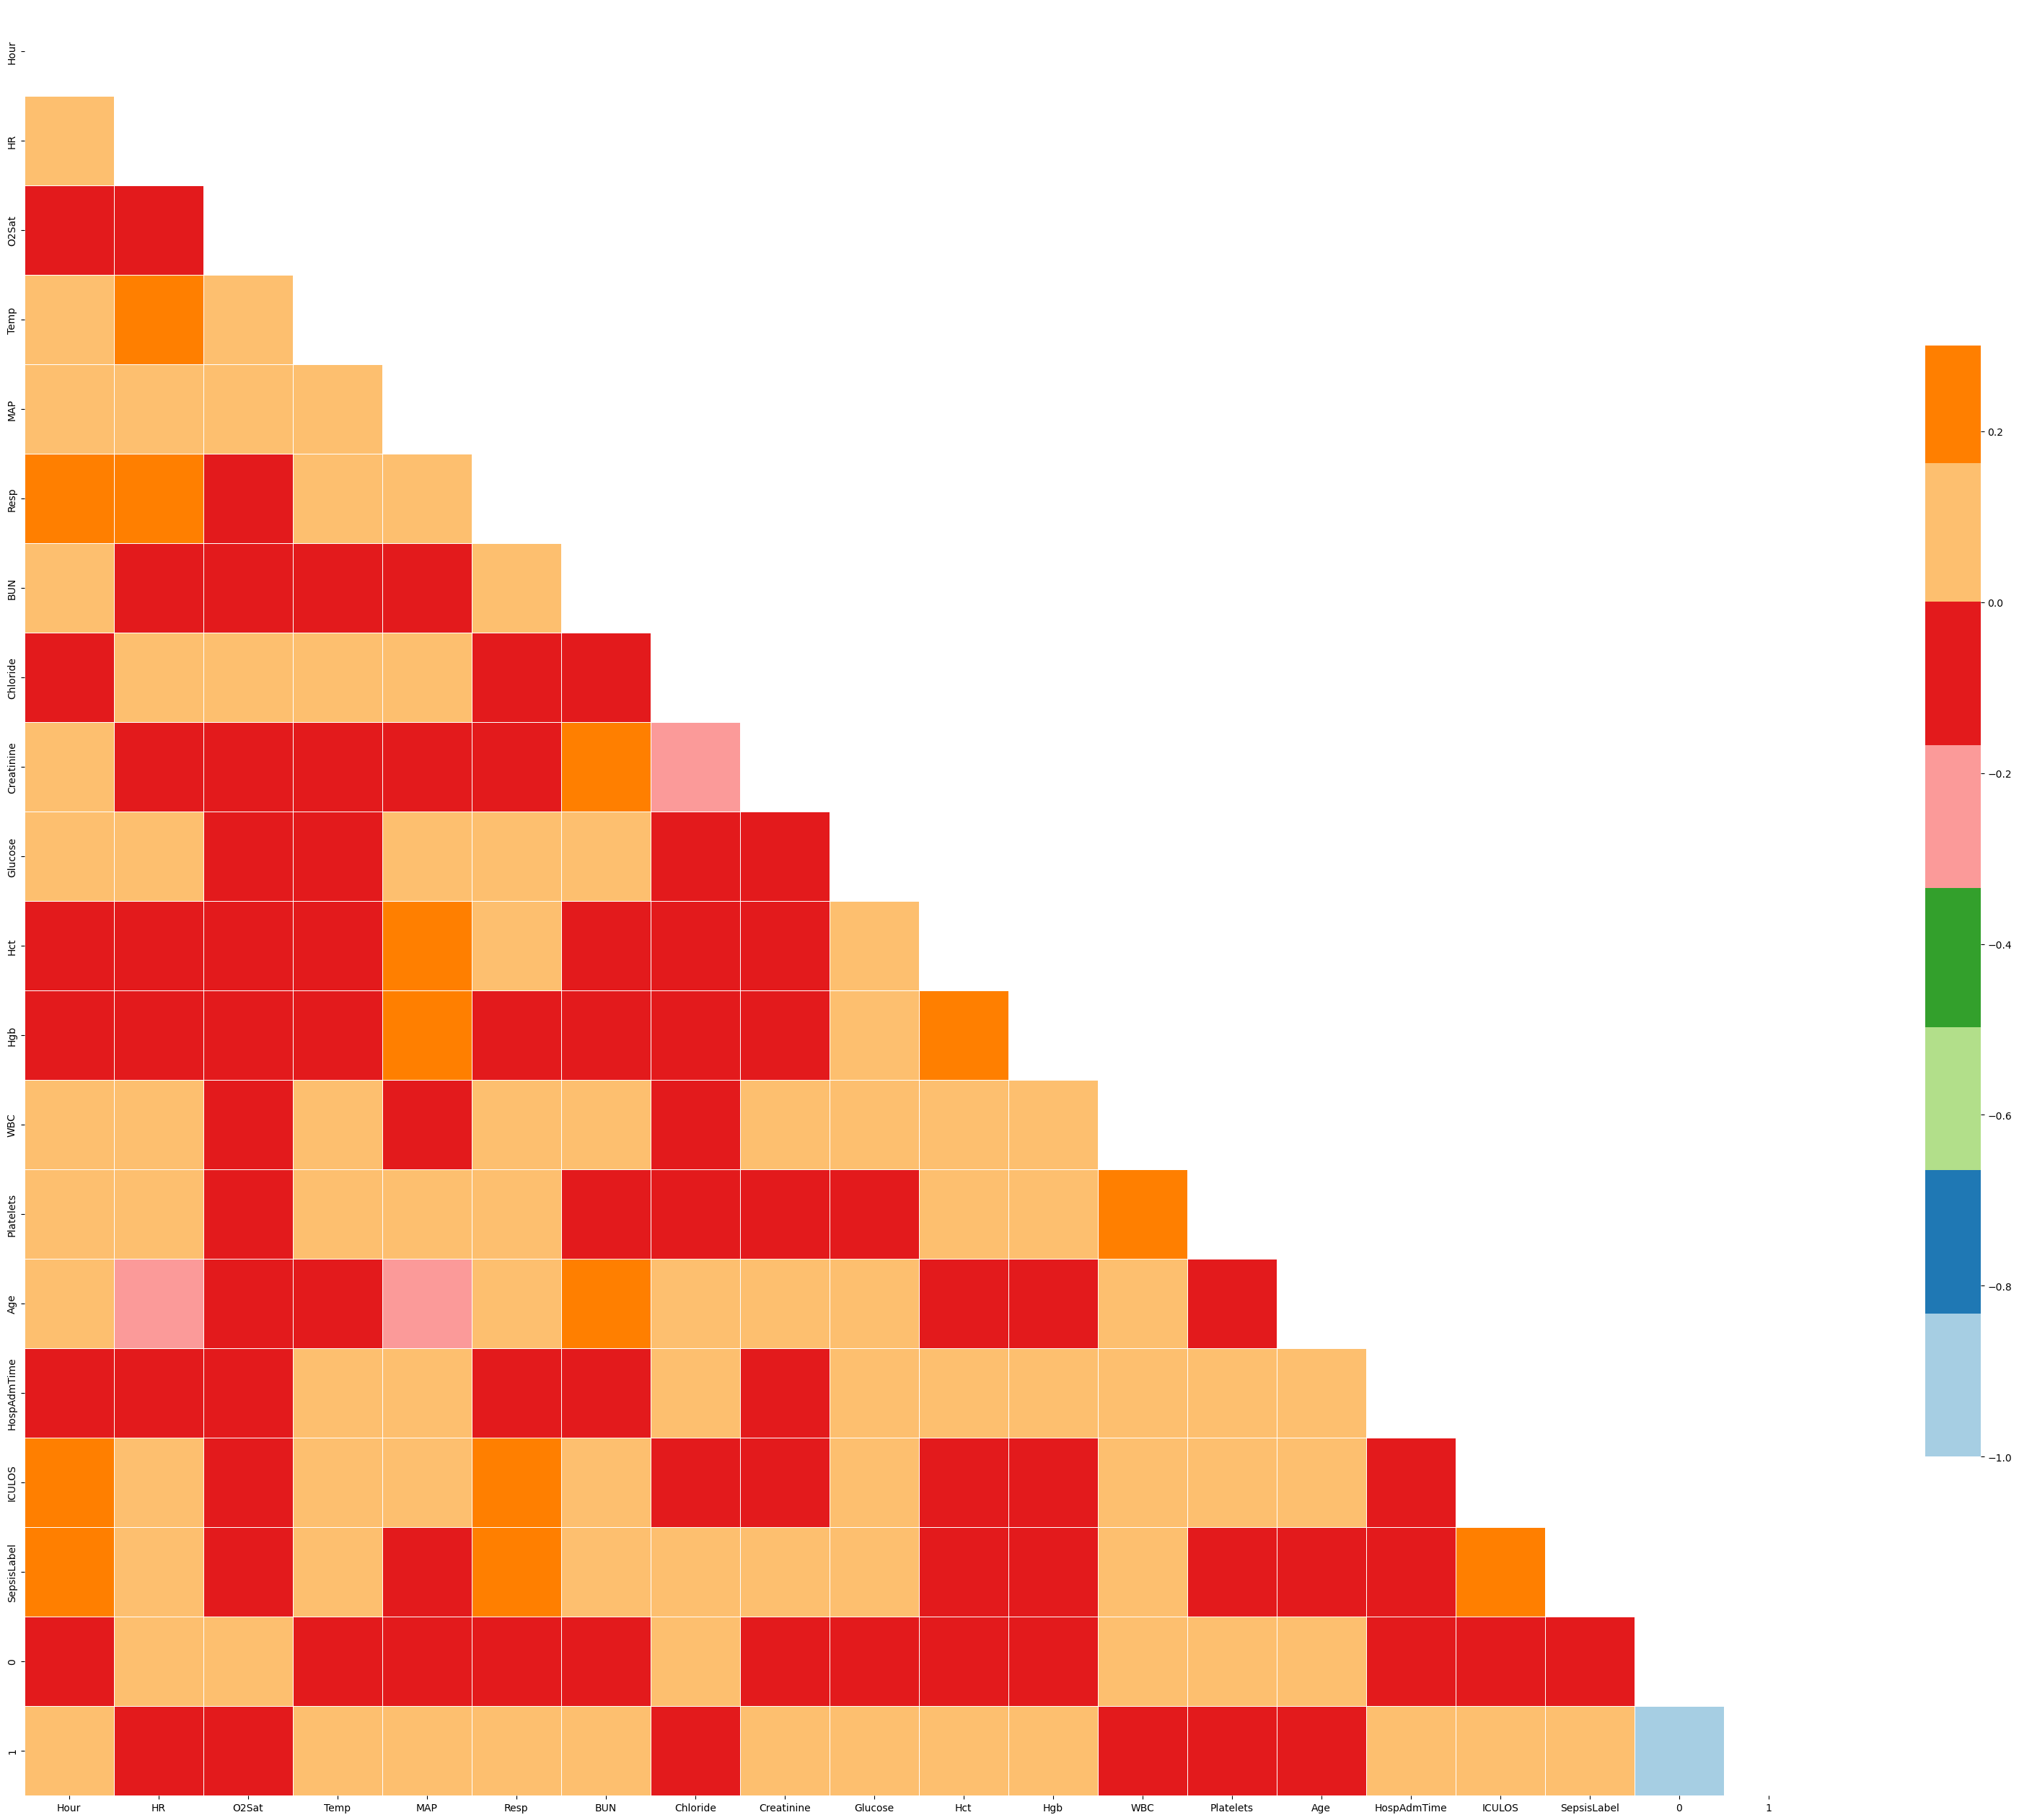

In [31]:
corr_matrix(df_train_impute)

In [32]:
df_train_impute.columns.map(type)

Index([<class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>,
       <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>,
       <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>,
       <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>,
       <class 'str'>, <class 'str'>, <class 'int'>, <class 'int'>],
      dtype='object')

In [33]:
df_train_impute.columns=df_train_impute.columns.astype(str)

In [34]:
df_train_impute.columns.map(type)

Index([<class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>,
       <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>,
       <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>,
       <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>,
       <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>],
      dtype='object')

In [35]:
# train test split for the imputed output

X = df_train_impute.drop('SepsisLabel', axis=1)
y = df_train_impute['SepsisLabel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=108)

In [36]:
# random forest classifier
# random forest classifier was tested on different hyper parameters and it gave the best results with number of estimators as 300

# model = RandomForestClassifier(n_estimators=100, random_state=0)
# model = RandomForestClassifier(n_estimators=200, random_state=0)
model = RandomForestClassifier(n_estimators=300, random_state=0)
model.fit(X_train, y_train)
rcf_predictions = model.predict(X_test)

Accuracy: 0.962381419692509
Precision: 0.9298857868020305
Recall: 0.9594108019639934
F1 Score: 0.944417593040116
AUC-ROC: 0.961638036691611
Mean Absolute Error: 0.037618580307491004
Root Mean Squared Error: 0.19395509868908062


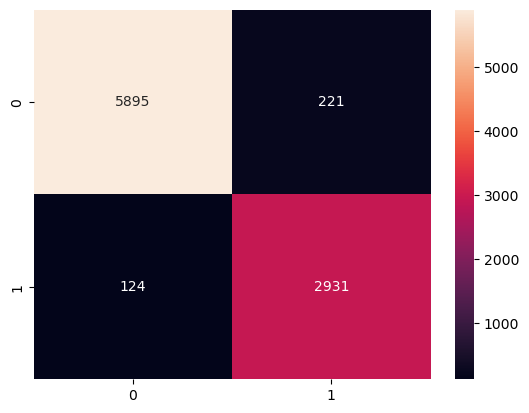

In [37]:
evaluate_model(y_test,rcf_predictions)

Accuracy: 0.750517936975248
Precision: 0.7058507783145465
Recall: 0.43044189852700493
F1 Score: 0.5347702318015454
AUC-ROC: 0.6704204260457131
Mean Absolute Error: 0.24948206302475193
Root Mean Squared Error: 0.49948179448779906


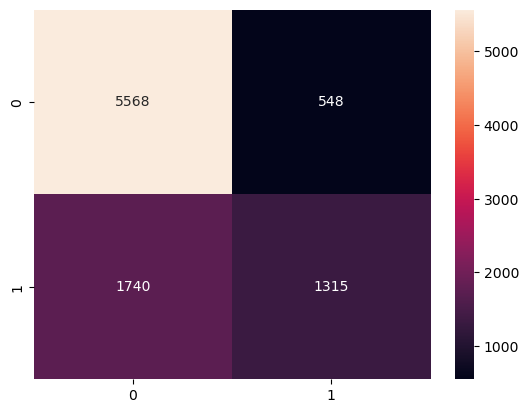

In [38]:
# Naive Bayes Classifier
# NBC performed worse than random forest on each and every aspect of the evaluation metrics

from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)
nbc_predictions = model.predict(X_test)
evaluate_model(y_test,nbc_predictions)

Accuracy: 0.8208483262457748
Precision: 0.7747081712062257
Recall: 0.6517184942716857
F1 Score: 0.7079111111111112
AUC-ROC: 0.7785243877506237
Mean Absolute Error: 0.17915167375422528
Root Mean Squared Error: 0.42326312590896137


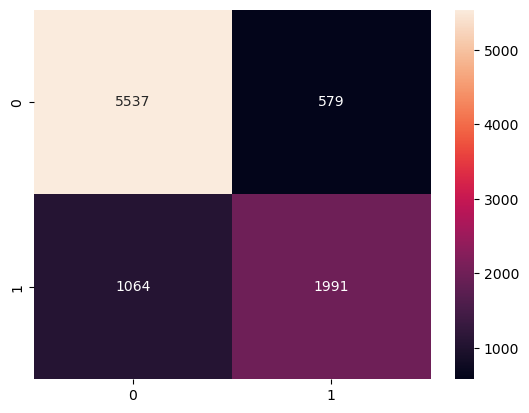

In [39]:
# KNN Classifier
# KNN was tested on different values of k

from sklearn.neighbors import KNeighborsClassifier
# model = KNeighborsClassifier(n_neighbors=8)
# model = KNeighborsClassifier(n_neighbors=5)
model = KNeighborsClassifier(n_neighbors=10)
model.fit(X_train, y_train)
knn_predictions = model.predict(X_test)
evaluate_model(y_test,knn_predictions)

Accuracy: 0.7510631337912986
Precision: 0.7449238578680203
Recall: 0.3842880523731588
F1 Score: 0.5070179226948823
AUC-ROC: 0.6592794087895879
Mean Absolute Error: 0.24893686620870134
Root Mean Squared Error: 0.49893573354561543


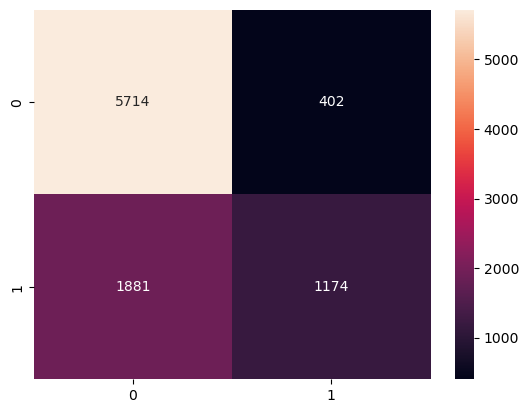

In [40]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear',random_state=0)
model.fit(X_train, y_train)
lr_predictions = model.predict(X_test)
evaluate_model(y_test,lr_predictions)

In [41]:
!pip install xgboost

Accuracy: 0.8592301820957365
Precision: 0.8308327081770442
Recall: 0.7250409165302782
F1 Score: 0.77434015032337
AUC-ROC: 0.8256499546680168
Mean Absolute Error: 0.14076981790426343
Root Mean Squared Error: 0.37519304085265687


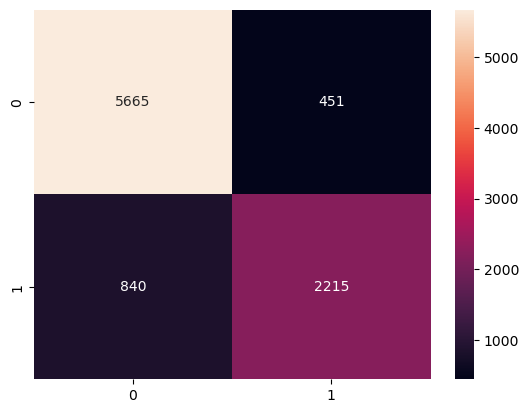

In [42]:
# XGBoost
# XGBoost was run for different combinations of hyperparameters, but overall random forest classifier performed the best in terms of F1 score and other metrics 

import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
param = {
    'max_depth': 5,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
#     'silent': 1,  # logging mode - quiet
    'objective': 'binary:logistic'}  # error evaluation for binary classification
num_round = 100
bst = xgb.train(param, dtrain, num_round)
xgb_predictions = bst.predict(dtest)
prediction = []
for i in xgb_predictions:
  if i<0.5:
    prediction.append(0)
  else:
    prediction.append(1)
evaluate_model(y_test,prediction)

Accuracy: 0.7496946698072058
Precision: 0.7406143344709898
Recall: 0.38334205705312746
F1 Score: 0.5051950851476611
AUC-ROC: 0.6581065166186862
Mean Absolute Error: 0.2503053301927942
Root Mean Squared Error: 0.5003052370231539


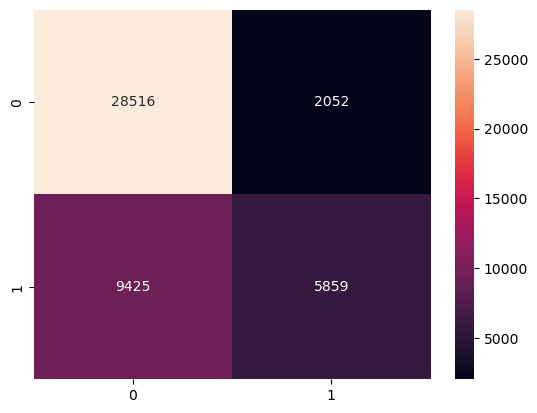

In [43]:

# df = get_data_ready(df_test)
# X = df_train_impute.drop('SepsisLabel', axis=1)
# y = df_train_impute['SepsisLabel']
rcf_predictions = model.predict(X)
evaluate_model(y,rcf_predictions)

In [44]:
from sklearn.metrics import accuracy_score,log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC,LinearSVC,NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from mlxtend.classifier import StackingClassifier
classifiers=[
    MLPClassifier(
    activation='tanh',
    solver='lbfgs',
    early_stopping=False,
    hidden_layer_sizes=(40,10,10,10,10,2),
    random_state=1,
    batch_size='auto',
    max_iter=13000,
    learning_rate_init=1e-5,
    tol=1e-4,
),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    RandomForestClassifier()
]

log_cols=["Classifier","Accuracy","Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train,y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

/Users/sumanthreddy/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/var/folders/4g/0ybq4ybd6n513hlrs2dc69d80000gn/T/ipykernel_3769/3722179034.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(log_entry)


MLPClassifier
****Results****
Accuracy: 78.4102%
Log Loss: 0.48020811471766756
AdaBoostClassifier
****Results****
Accuracy: 77.4943%
Log Loss: 0.6835920435117578


/var/folders/4g/0ybq4ybd6n513hlrs2dc69d80000gn/T/ipykernel_3769/3722179034.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(log_entry)


GradientBoostingClassifier
****Results****
Accuracy: 78.4974%
Log Loss: 0.4699833044535248
GaussianNB
****Results****
Accuracy: 75.0518%
Log Loss: 0.9545639551796761
LinearDiscriminantAnalysis
****Results****
Accuracy: 74.7138%
Log Loss: 0.5385260487148157


/var/folders/4g/0ybq4ybd6n513hlrs2dc69d80000gn/T/ipykernel_3769/3722179034.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(log_entry)
/var/folders/4g/0ybq4ybd6n513hlrs2dc69d80000gn/T/ipykernel_3769/3722179034.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(log_entry)
/var/folders/4g/0ybq4ybd6n513hlrs2dc69d80000gn/T/ipykernel_3769/3722179034.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(log_entry)
/Users/sumanthreddy/anaconda3/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/var/folders/4g/0ybq4ybd6n513hlrs2dc69d80000gn/T/ipykernel_3769/3722179034.py:51: Future

QuadraticDiscriminantAnalysis
****Results****
Accuracy: 71.7588%
Log Loss: 1.1696115119285253
RandomForestClassifier
****Results****
Accuracy: 96.0201%
Log Loss: 0.19301442085365442


/var/folders/4g/0ybq4ybd6n513hlrs2dc69d80000gn/T/ipykernel_3769/3722179034.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(log_entry)


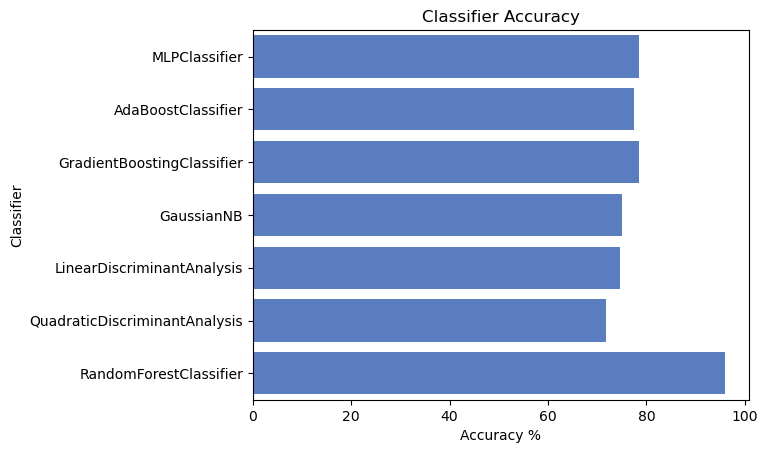

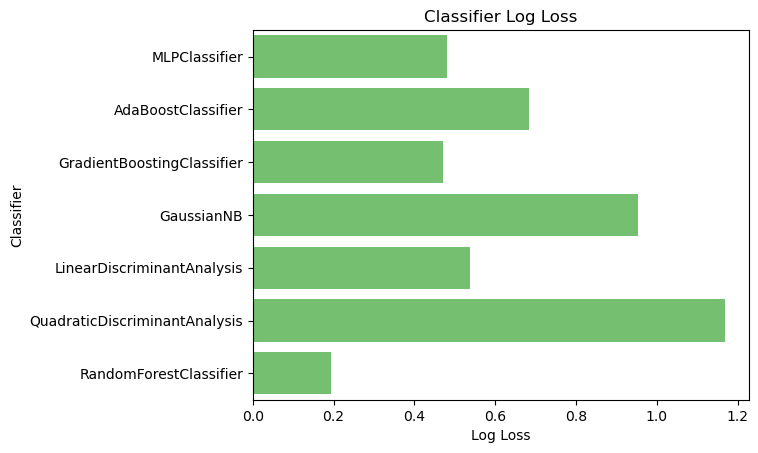

In [45]:
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

In [46]:
KNC = KNeighborsClassifier() # initialising KNeighbors Classifier
NB = GaussianNB() # initialising Naive Bayes
RFC = RandomForestClassifier() #intialising Random Forest Classifier

In [47]:
model_RandomForestClassifier = RFC.fit(X_train, y_train) # fitting Training Set
pred_rfc = model_RandomForestClassifier.predict(X_test) # Predicting on test dataset

In [48]:
acc_rfc = accuracy_score(y_test, pred_rfc) # evaluating accuracy score
print('accuracy score of RandomForest Classifier is:', acc_rfc * 100)

accuracy score of RandomForest Classifier is: 95.9655435612256


In [49]:
model_kNeighborsClassifier = KNC.fit(X_train, y_train) # fitting Training Set
pred_knc = model_kNeighborsClassifier.predict(X_test) # Predicting on test dataset

In [50]:
acc_knc = accuracy_score(y_test, pred_knc) # evaluating accuracy score
print('accuracy score of KNeighbors Classifier is:', acc_knc * 100)

accuracy score of KNeighbors Classifier is: 86.64267800676045


In [51]:
model_NaiveBayes = NB.fit(X_train, y_train)
pred_nb = model_NaiveBayes.predict(X_test)

In [52]:
acc_nb = accuracy_score(y_test, pred_nb)
print('Accuracy of Naive Bayes Classifier:', acc_nb * 100)

Accuracy of Naive Bayes Classifier: 75.0517936975248


In [53]:
pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


In [54]:
from mlxtend.classifier import StackingClassifier
lr = LogisticRegression() # defining meta-classifier
clf_stack = StackingClassifier(classifiers =[RFC,NB,KNC], meta_classifier = lr, use_probas = True, use_features_in_secondary = True)

In [55]:
model_stack = clf_stack.fit(X_train, y_train) # training of stacked model
pred_stack = model_stack.predict(X_test)	 # predictions on test data using stacked model

/Users/sumanthreddy/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy score of Stacked model: 96.00915930650964
Accuracy: 0.9600915930650965
Precision: 0.9299648225135912
Recall: 0.9518821603927987
F1 Score: 0.9407958589453251
AUC-ROC: 0.9580372214652025
Mean Absolute Error: 0.0399084069349035
Root Mean Squared Error: 0.19977088610431576


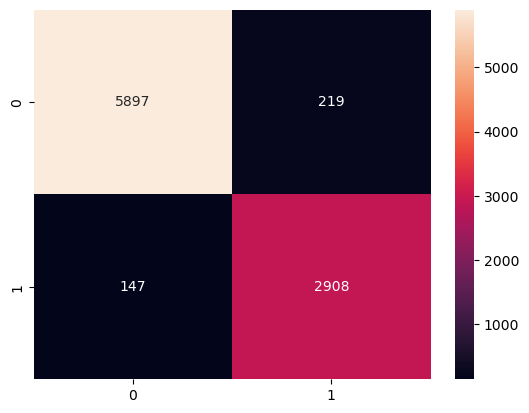

In [56]:
acc_stack = accuracy_score(y_test, pred_stack) # evaluating accuracy
print('accuracy score of Stacked model:', acc_stack * 100)
evaluate_model(y_test, pred_stack)